In [1]:
# %matplotlib widget
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json
from copy import deepcopy

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# style.use('default')
style.use('S:\Connie\prx.mplstyle')

import Pyro4.util

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [6]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Set the qubits/resonators to probe

## [Auto0] SET 2Q QUBIT SWAP PARAMETERS

In [135]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
wrong_init_state = '|1>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

# qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
# init_state = '|1>|1>' # for everything else
# wrong_init_state = '|0>|1>'
# setup_ZZ = 0 # for the amp rabi chevron
# # measure_qubits = [qubits[0], qubits[1], 2]
# measure_qubits = qubits
# qDrive = qubits[0] # normal new protocol

# init_state = '|0>|2>'
# qDrive = qubits[1]


# f0-g1
# # init_state = '|0>|0>'
# # qDrive = 1 # resonator f0-g1

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [8]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium

In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# ZZ shifted pi pulses

## Pulse probe coupling spectroscopy

Sweep qubit A frequency after applying pi pulse to qubit B.

In [101]:
qubits = [1, 2] # for eg-gf swap, always list the 2nd qubit here as the 2nd qubit in the order eg-gf

In [ ]:
qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_coupling_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1
npts = 100

qZZspec.cfg.expt = dict(
    start=qZZspec.cfg.device.qubit.f_Q1_ZZ[qubits[1]]-span/2,
    # start=qZZspec.cfg.device.qubit.f_ge[qubits[0]]-span/2,
    # start=3458.5-span/2,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    pulseB=True, # Whether to apply pi pulse to qubit B
    length=1, # qubit 0 probe constant pulse length [us]
    gain=100, # qubit 0 const pulse gain
    pulse_type='gauss',
    qubits=qubits,
)

# qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qZZspec.cfg)

qZZspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qZZspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_coupling_spectroscopy_qubit01.h5')
# data = qZZspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qZZspec.display(data=data, fit=True)

qZZspec.analyze(fit=True, signs=[1, -1, 1])
qZZspec.display(fit=True, signs=[1, -1, 1])

In [ ]:
qZZspec.save_data()

## Length rabi for Q1 with QA in e

In [ ]:
lengthrabiZZ = meas.LengthRabiPiZZExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_ZZ_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

lengthrabiZZ.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=101,
    reps=1000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubits=qubits,
)
# lengthrabiZZ.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]

print(lengthrabiZZ.cfg)
# lengthrabi.im[lengthrabi.cfg.aliases.soc].reset()
lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabiZZ.analyze(data=temp_data, fit=True)

lengthrabiZZ.analyze(fit=True)
lengthrabiZZ.display(fit=True)

In [ ]:
lengthrabiZZ.save_data()

# 2Q swap frequencies

Estimate 2Q swap frequencies analytically

In [ ]:
f_ge = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
f_ef = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)

print('f_EgGf: need indices 0, 2, 3')
print(f_ge[1] + f_ef[1] - f_ge)
print('f_EgGf_Q: indices 2, 3')
print(f_ge[2] + f_ef[2] - f_ge[1])
print(f_ge[3] + f_ef[3] - f_Q1_ZZ[0])
print('f_EgGf for Q3 if switch is in g')
print(f_ge[3] + f_ef[3] - f_ge[1])
print('f_EgGf for Q2 if switch is in 3')
print(f_ge[2] + f_ef[2] - f_Q1_ZZ[0])

## Pulse probe eg-gf spectroscopy

In [ ]:
qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EgGf_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 40
npts = 150

qEgGfspec.cfg.expt = dict(
    # start=qEgGfspec.cfg.device.qubit.f_ge[1] - span/2, # Eg-Gf probe frequency [MHz]
    start=qEgGfspec.cfg.device.qubit.f_EgGf[qubits[0]] - span/2, # Eg-Gf probe frequency [MHz]
    # start=1900,
    step=span/npts,
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=10, # Number of start to finish sweeps to average over
    length=2, # Eg-Gf probe constant pulse length [us]
    gain=3000, # Eg-Gf const pulse gain
    qubits=qubits,
)
# qEgGfspec.cfg.device.readout.relax_delay = [50]*4
# qEgGfspec.cfg.device.readout.relax_delay = [100, 100, 100, 100]
# qEgGfspec.cfg.device.readout.length = [5, 5, 5, 5]

print(qEgGfspec.cfg)

qEgGfspec.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# qEgGfspec = meas.PulseProbeEgGfSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00002_qubit_EgGf_spectroscopy_qubit01.h5')
# data = qEgGfspec.analyze(data=temp_data, fit=True, sign=[[1, -1], [-1, -1]])
# qEgGfspec.display(data=data, fit=True)

# qEgGfspec.analyze(fit=False)
sign = [[1, -1], [-1, 1]] # [iA, qA], [iB, qB]
qEgGfspec.analyze(fit=True, sign=sign)
qEgGfspec.display(fit=True, sign=sign)

In [ ]:
qEgGfspec.save_data()

### Pulse probe EgGF power sweep

In [ ]:
sweepspecEgGf = meas.PulseProbeEgGfSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"pulse_probe_ef_len_sweep_spectroscopy_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_f = 75
npts_f = 150
# npts_f = 10

span_len = 20
npts_len = 10
# npts_len = 3

sweepspecEgGf.cfg.expt = dict(
    start_f=sweepspecEgGf.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # Eg-Gf probe frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_len=1,
    step_len=int(span_len/npts_len), # len step size
    expts_len=npts_len, # Number experiments stepping len from start
    reps=500,
    rounds=40, # Number averages per point
    gain=30000, # ef const pulse length [us]
    qubits=qubits,
)
sweepspecEgGf.cfg.device.readout.relax_delay = [100, 100, 100, 100]
sweepspecEgGf.cfg.device.readout.length = [5, 5, 5, 5]
sweepspecEgGf.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = rpowspec.analyze(data=temp_data, lowgain=2000, highgain=18000)

sweepspecEgGf.analyze()
sweepspecEgGf.display()

In [ ]:
3452+3318-4763

## [Auto1] Rabi eg-gf chevron (freq vs. amplitude)

In [91]:
rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqgain_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span_gain = 25000
# span_gain = 7000
# npts_gain = 10
# span_gain = 0
# npts_gain = 25
npts_gain = 20

span_f = 26 # MHz
# npts_f = 5
# span_f = 0
# npts_f = 100
npts_f = 50
# npts_f = 15

rabiEgGfFreqGainChevron.cfg.expt = dict(
    start_gain=7000, # qubit gain [dac level]
    # start_gain=18000, # qubit gain [dac level]
    step_gain=int(span_gain/npts_gain), # [dac level]
    expts_gain=npts_gain,
    # start_f=2012 - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - span_f/2, # start freq [MHz],
    # start_f=rabiEgGfFreqGainChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 5 - span_f/2, # start freq [MHz],
    start_f=5122,
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f, # number of different freq experiments, 
    reps=40,
    rounds=10,
    pi_EgGf_sigma=0.200, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='flat_top',
    # pulse_type='const',
    setup_ZZ=setup_ZZ,
    # setup_ZZ=None,
    qDrive=qDrive,
    # qDrive=1,
    qubits=qubits,
    measure_qubits=measure_qubits,

    # full_mux_expt=True,
    # resonator_reset=[0, 2, 3],
)

# rabiEgGfFreqGainChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqGainChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print('qDrive', qDrive)
print(rabiEgGfFreqGainChevron.cfg)

rabiEgGfFreqGainChevron.go(analyze=False, display=False, progress=True, save=False)

qDrive 3
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.17, 0.035, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-440.97500000000036, 0.0, 453.3682333333336, -280.35364238410557], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.5530242338505, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.313815659153, 4108.147701523904, 4114.310372455052, 4114.310372455052, 3443.0032303441935, 3448.345849629168, 0, 0, 4763.941, 4763.941, 4763

  0%|          | 0/50 [00:00<?, ?it/s]

In [96]:
# # TESTING
# rabiEgGfFreqGainChevron = meas.EgGfFreqGainChevronExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\QRAM\qram_4QR2\data\data_240508\\00001_rabi_EgGf_freqgain_chevron_qubit31.h5')
# rabiEgGfFreqGainChevron.cfg.expt = attrs['config']['expt']
# # print(temp_data.keys())
# # rabiEgGfFreqGainChevron.display(data=temp_data, saveplot=True) #, plot_freq=2024.5, plot_gain=2125)
# data = rabiEgGfFreqGainChevron.analyze(data=temp_data, fit=True)
# rabiEgGfFreqGainChevron.display(data=data, fit=True)

data = rabiEgGfFreqGainChevron.analyze(data=None, fit=True)
rabiEgGfFreqGainChevron.display(fit=True, data=data) #, plot_freq=5883.9, plot_gain=21000)


plt.figure()
plot_gain = 15000
# plot_gain = rabiEgGfFreqGainChevron.cfg.device.qubit.pulses.pi_EgGf_Q.gain[qubits[0]]
gain_ind = np.argmin(np.abs(data['gainpts']-plot_gain))
# for i in range(len(data['lenpts'])):
#     plt.plot(data['freqpts'], data['avgi'][0][:, i])

amps_freq_cut_qA = data['amps'][0][:, gain_ind]
amps_freq_cut_qB = data['amps'][1][:, gain_ind]

p_ampsA = data['fitamps'][0][gain_ind]
# print(p_ampsA)
fit_amps_freq_cut_qA = meas.fitting.rabifunc(data['freqpts'], *p_ampsA)
plt.suptitle(f"Cut through gain {data['gainpts'][gain_ind]} us")
plt.subplot(211, title=f'QA ({qubits[0]})')
plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
# plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
plt.ylabel('Amplitude [ADC units]')

plt.subplot(212, title=f'QB ({qubits[1]})')
plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
# plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
# plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
plt.tight_layout()
plt.show()


QA: max at gain 18250 freq 5141.24
QB: min at gain 27000 freq 5139.68
fit_gain_sweep = [7000, 8250, 9500, 10750, 12000, 13250, 14500, 15750, 17000, 18250, 19500, 20750, 22000, 23250, 24500, 25750, 27000, 28250, 29500, 30750]
fit_freqs = [5147.125542274293, 5147.049197312618, 5146.832384247643, 5146.475103079366, 5145.977353807789, 5145.339136432911, 5144.560450954733, 5143.641297373253, 5142.581675688473, 5141.3815859003935, 5140.041028009012, 5138.56000201433, 5136.938507916348, 5135.176545715065, 5133.2741154104815, 5131.231217002597, 5129.047850491412, 5126.724015876926, 5124.25971315914, 5121.654942338053]


 C:\Users\slab\AppData\Local\Temp\ipykernel_8888\3957768405.py: 40

In [246]:
rabiEgGfFreqGainChevron.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00002_rabi_EgGf_freqgain_chevron_qubit31.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00002_rabi_EgGf_freqgain_chevron_qubit31.h5'

## Length rabi chevron eg-gf (freq vs. len)

1. Once picked a good gain/len/freq, make sure the freq is really dialed in by doing a cut through the length.
2. Calibrate simultaneous pulses by doing the same thing while playing the other pulse

In [ ]:
rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_f = 10 # MHz
span_f = 1.5 # MHz
npts_f = 100
# npts_f = 25

# start_len = 0.0
# span_len = 1.5*rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# npts_len = 15
start_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
span_len = 0
npts_len = 1

print(measure_qubits)
print(qubits)
  
rabiEgGfFreqLenChevron.cfg.expt = dict(
    # start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf[qubits[0]] - span_f/2 - 20, # start freq [MHz],
    start_f=rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]] - 0.5*span_f, # start freq [MHz],
    step_f=span_f/npts_f, # freq step, 
    expts_f=npts_f+1, # number of different freq experiments, 
    start_len=start_len, # pulse length (sigma) [us]
    step_len=span_len/npts_len, # [us]
    expts_len=npts_len,
    # gain=30000,
    # reps=800,
    reps=2000,
    loops=1,
    pulse_type='flat_top',
    post_process=None, #'threshold',
    # singleshot_reps=10000,
    # sigma_ramp_cycles=10,
    measure_f=None,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    # qubits_simulswap=[2, 1],
    # qDrive_simul=2,
)

# rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
# rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(rabiEgGfFreqLenChevron.cfg)

try:
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = rabiEgGfFreqLenChevron.analyze(data=None, fit=False)
rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, -1, -1, 1])

rabiEgGfFreqLenChevron.data = data

# print('Saved', rabiEgGfFreqLenChevron.save_data())

plt.figure(figsize=(9, 8))
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
# for i in range(len(data['lenpts'])):
#     plt.plot(data['freqpts'], data['avgi'][0][:, i])

amps_freq_cut_qA = data['amps'][0][:, len_ind]
amps_freq_cut_qB = data['amps'][1][:, len_ind]
p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
print('QA freq with max amp', freq_max_amp_qA)
print('QB freq with min amp', freq_min_amp_qB)
plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
plt.subplot(211, title=f'QA ({qubits[0]})')
plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
plt.ylabel('Amplitude [ADC units]')

plt.subplot(212, title=f'QB ({qubits[1]})')
plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
# plt.axvline(5890.45, color='r', linestyle='--')
# plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude [ADC units]')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(data['freqpts'], amps_freq_cut_qA+amps_freq_cut_qB, '.-', label='qA+qB', color=default_colors[0])


In [ ]:
filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00123_rabi_EgGf_freqlen_chevron_qubit21.h5'
# filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00025_rabi_EgGf_freqlen_chevron_qubit31.h5'

rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=None,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)
temp_data, attrs = prev_data(filename, None)
data = temp_data
data = deepcopy(data)

# # print(temp_data['amps'].shape)
# # print(data['amps'].shape)
# for fit_axis in ['amps', 'avgi', 'avgq']:
#     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# print(data['freqpts'])
# rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

rabiEgGfFreqLenChevron.data = data
rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
if qubits[0] == 3: sign = 1
elif qubits[0] == 2: sign = -1
good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

plt.style.use('dark_background')

rows = 2
cols = 1
index = rows*100 + cols*10
fig, axs = plt.subplots(rows, cols, figsize=(9*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
ax1, ax2 = axs
plt.suptitle("$|eg\\rangle-|gf\\rangle$"+ f" Frequency vs. Length (Q{qubits[0]}/Q{qubits[1]})")

plt.sca(ax1)
data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=0, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# print(((data['freqpts'][-1] - data['freqpts'][0])//4))
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.yticks(ticks=yticks, fontsize=24)
plt.ylabel('Frequency\n(MHz)', fontsize=24)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[0]}')

plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
data['amps'][1] = (data['amps'][1] - max(data['amps'][1])) / (min(data['amps'][1]) - max(data['amps'][1]))
rabiEgGfFreqLenChevron.plot_rabi_chevron(data, 'amps', plot_xpts=1000*data['lenpts'], plot_ypts=data['freqpts'], plot_rabi=False, q_index=1, show_cbar=False)
# plt.axhline(bad_ZZ_freq, color='r', linestyle='--')
# yticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
yticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
plt.ylabel('Frequency\n(MHz)', fontsize=24)
plt.xlabel('Length (ns)', fontsize=24)
plt.yticks(ticks=yticks, fontsize=24)
plt.xticks(fontsize=24)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=16)
cbar.set_label(f'Population (Scaled)', size='large')
# cbar.ax.set_title(f'Q{qubits[1]}')

plt.subplots_adjust(hspace=0.07)
# plt.tight_layout()

plot_filename = filename[:-3]+'.svg'
plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
print('Saved', plot_filename)

plt.show()




# # filename = 's:\Connie\experiments\qramLL_4QR2\data\data_240218\\00122_rabi_EgGf_freqlen_chevron_qubit21.h5'
# # temp_data, attrs = prev_data(filename, None)
# # data = temp_data
# # data = deepcopy(data)

# # # print(temp_data['amps'].shape)
# # # print(data['amps'].shape)
# # for fit_axis in ['amps', 'avgi', 'avgq']:
# #     data[fit_axis] = np.concatenate((temp_data[fit_axis], data[fit_axis]), axis=1)
# # data['freqpts'] = np.concatenate((temp_data['freqpts'], data['freqpts']), axis=None)

# # print(data['freqpts'])
# # rabiEgGfFreqLenChevron.display(data=data, fit=False, signs=[-1, 1, -1, 1])

# rabiEgGfFreqLenChevron.data = data
# rabiEgGfFreqLenChevron.cfg = AttrDict(attrs['config'])
# qubits = rabiEgGfFreqLenChevron.cfg.expt.qubits
# if qubits[0] == 3: sign = 1
# elif qubits[0] == 2: sign = -1
# good_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
# bad_ZZ_freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]+sign*rabiEgGfFreqLenChevron.cfg.device.qubit.ZZs[1]

# plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
# len_ind = np.argmin(np.abs(data['lenpts']-plot_len))


# fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 7), gridspec_kw={'height_ratios': [1, 1]}, sharex='col')
# ax1, ax2 = axs
# plt.suptitle(f"Q{qubits[0]} Cut Through Length {data['lenpts'][len_ind]:.3} ns")

# plt.sca(ax1)
# data['amps'][0] = (data['amps'][0] - min(data['amps'][0])) / (max(data['amps'][0]) - min(data['amps'][0]))
# plt.plot(data['freqpts'], data['amps'][0][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)

# plt.sca(ax2)
# data['amps'][1] = (data['amps'][1] - min(data['amps'][1])) / (max(data['amps'][1]) - min(data['amps'][1]))
# plt.plot(data['freqpts'], data['amps'][1][:, len_ind], '.-')
# # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
# plt.ylabel('Population\n(Scaled)', fontsize=24)
# plt.xlabel('Frequency (MHz)', fontsize=24)
# plt.yticks(ticks=[0, 0.5, 1.0], fontsize=24)
# # xticks = int(np.average(data['freqpts'])) + (data['freqpts'][-1] - data['freqpts'][0])//3*np.arange(-1, 2) 
# xticks = [round(good_ZZ_freq), round(bad_ZZ_freq)] 
# plt.xticks(ticks=xticks, fontsize=24)

# plt.subplots_adjust(hspace=0.07)

# plot_filename = filename[:-3]+f'_cut.svg'
# plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
# print('Saved', plot_filename)

# plt.show()

## Length Rabi eg-gf single sweep

In [16]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 2*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 15
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0.001*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
npts_len = 50


lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    # reps=15000,
    # reps_f=25000,
    reps=4000,
    # reps_f=1000,
    loops=5,
    pulse_type='flat_top',
    post_process=None,
    # post_process=None,
  
    # singleshot_reps=40000,
    # singleshot_reps=1000,
    measure_f=None,
    # measure_f=[qDrive],
    init_state=init_state,
    # init_state=wrong_init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    test_pi_half=False,
    readout_cool=False,
)

# lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-389.9452717544333, 5795.711666663333, 502.368233333334, -228.85410723], 'gain': [0.3, 0.3, 0.85, 0.85], 'readout_length': [15.0, 10.0, 5.0, 15.0], 'frequency_ef': [-391.80446161500305, 5794.287237348879, 500.35983051204073, -230.41370987900663], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.1402562265434, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.1402562265434, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.69860

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [17]:
lengthrabiEgGf.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00038_length_rabi_EgGf_qubit21.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00038_length_rabi_EgGf_qubit21.h5'

In [18]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

lengthrabiEgGf.analyze(fit=True, post_select_calib=False, post_select_experiment=False, separate_correction=False, ps_qubits=[0, 1, 2], verbose=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()

lengthrabiEgGf.display(fit=False)

# print(lengthrabiEgGf.data['counts_calib'])

max QA amp: 2497.3601865907235
min QA amp: 1473.1046422472596
max QB amp: 662.2861424676338
min QB amp: 440.8415926730564


[None, None, None, None]

### Length rabi with post selection

In [340]:
lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# start_len = lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 0
# npts_len = 10

start_len = 0
# span_len = 3.75*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
span_len = 1.0*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 15
# start_len = 0.999*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# span_len = 2*lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
# npts_len = 50
npts_len = 1

lengthrabiEgGf.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    # step=0,
    # expts=1,
    step=span_len/npts_len, # [us]
    expts=npts_len+1,
    reps=20000,
    # reps_f=20000,
    # reps=100,
    reps_f=10,
    loops=1,
    pulse_type='flat_top',
    post_process='threshold',
    # post_process=None,
  
    # singleshot_reps=500,
    singleshot_reps=20000,
    singleshot_reps_f=10,
    # singleshot_reps=100,
    # measure_f=None,
    measure_f=[qDrive],
    init_state=init_state,
    # init_state='test',
    # init_state='|1+0>|1>',
    # init_state='|1>|0+1>',
    # init_state='Q2Q1_|2>|0>',
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
    
    # setup_measure='qDrive_ef',

    test_pi_half=False,
    # cool_qubits=[0, 1],
    # cool_idle=[5, 5],
    
    readout_cool=True,
    n_init_readout=1,
    n_trig=1,
    init_read_wait_us=2,

    resonator_reset=[0, 2, 3],
    full_mux_expt=True,

    use_robust_pulses=True,

    n_cycles=3,
    skip_first_pi2=True,
    # plot_IQ=True,
    # init_read_wait_us=2,
    # use_gf_readout=True,
    
    # thresholds=[0, 403.4255711140312, 356.93670935384887, 0],
    # angles=[0, -15.164283291744868, 107.2178024864672, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [332.72639357096347, -312.0792793945312, 663.0205369628906, -231.3194316731771], [-55.472186757526444, -160.28748716436127, -169.05275673311635, -537.4039020748576], array([0., 0., 0., 0.])],
    # counts_calib=[[16091, 2293, 1360, 256], [2287, 16108, 208, 1397], [2399, 307, 14988, 2306], [414, 2510, 2206, 14870]]

)

lengthrabiEgGf.cfg.device.readout.gain[1] = 1e-4

print(lengthrabiEgGf.cfg)
# lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
try:
    lengthrabiEgGf.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.17, 0.0001, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-440.97500000000036, 0.0, 453.3682333333336, -280.35364238410557], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.5530242338505, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.313815659153, 4108.147701523904, 4114.310372455052, 4114.310372455052, 3450.0540893078382, 3448.3222547596297, 3450.0540893078382, 3450.054089307838

  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 1.1373618680934061 	 angle (deg): 0.0 	 threshold ge: 65.30879839340793
Qubit (2) ge
ge fidelity (%): 82.41461973098656 	 angle (deg): 0.0 	 threshold ge: 182.40361437614436


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 83.42999999999998 	 angle (deg): 0.0 	 threshold ge: 194.8369290303377


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 88.70477098854946 	 angle (deg): 0.0 	 threshold ge: 154.58295741523511


  0%|          | 0/2 [00:00<?, ?it/s]

q measure_f 2


  0%|          | 0/6 [00:00<?, ?it/s]

Qubit (1) ge
ge fidelity (%): 1.9715533276663644 	 angle (deg): 0.0 	 threshold gf: 90.41321657496057
Qubit (2) gf
gf fidelity (%): 4.464999999999996 	 angle (deg): 0.0 	 threshold gf: 269.71953252568005


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (0) ge
ge fidelity (%): 82.66999999999999 	 angle (deg): 0.0 	 threshold ge: 193.9230352861762


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit (3) ge
ge fidelity (%): 88.73979623981202 	 angle (deg): 0.0 	 threshold ge: 155.9392555039
thresholds_f=[193.9230352861762, 90.41321657496057, 269.71953252568005, 155.9392555039],
angles_f=[0.0, 0.0, 0.0, 0.0],
gf_avgs=[array([110.84428158,   0.        , 287.39802642,   0.        ]), array([73.63995055,  0.        , 75.28038023,  0.        ]), array([264.90995294,   0.        , 258.94048429,   0.        ]), array([ 73.82709541,   0.        , 268.70268844,   0.        ])],
counts_calib_f=[[7521, 6401, 3164, 2914], [8150, 5914, 3374, 2562], [7520, 6031, 3593, 2856], [7727, 5903, 3527, 2843], [7974, 5863, 3581, 2582], [8131, 5418, 3853, 2598]]


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
lengthrabiEgGf.save_data()

In [345]:
# # TESTING
# lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# lengthrabiEgGf.data = temp_data
# lengthrabiEgGf.cfg = AttrDict(attrs['config'])
# data = lengthrabiEgGf.analyze(data=temp_data, fit=True)
# lengthrabiEgGf.display(data=data, fit=False)

ps_qubits = [0, 2, 3]

ps_adjust = [-0.1, np.inf, -0.1, -0.1]

# ps_adjust = [-1.2, -1.0, -1.7, 0.0]
# ps_adjust_f = [-1.0, -1.0, -1.0, 0.0]
# ps_adjust_f = [-1, -1, np.inf, -1]
ps_adjust_f = [np.inf]*4

# ps_adjust = [np.inf]*4
# ps_adjust = None

apply_ps = True

# lengthrabiEgGf.analyze(fit=False, post_select_calib=apply_ps, post_select_experiment=apply_ps, separate_correction=False, ps_qubits=ps_qubits, ps_adjust=ps_adjust, ps_adjust_f=ps_adjust_f)

# lengthrabiEgGf.display(fit=False)

# plt.figure()
# print(lengthrabiEgGf.cfg.expt.measure_qubits)
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][0], label='q1')
# plt.plot(lengthrabiEgGf.data['xpts'], lengthrabiEgGf.data['amps'][1], label='q2')
# plt.ylabel('rotated amplitude')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 01, 10, 11
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 3], axis=0), label='q2 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][0, :, :, 2], axis=0), label='q2 g counts')
# plt.ylabel('counts measurement 0')
# plt.legend()
# plt.show()

# plt.figure()
# # 00, 02, 10, 12
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q1 e counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 3], axis=0), label='q2 f counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 0], axis=0) + np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 2], axis=0), label='q2 g counts')
# plt.plot(lengthrabiEgGf.data['xpts'], np.average(lengthrabiEgGf.data['counts_raw'][1, :, :, 1], axis=0), label='gf counts')
# plt.ylabel('counts measurement 1')
# plt.legend()
# plt.show()


data = lengthrabiEgGf.data
histdata = dict(iqshots=[])
check_states = []
# gg, ge, eg, ee, gf, ef q1/q2(q3), g(q0), e(q0), g(q2/3), e(q2/3)
loop = 0
imeasure = 0
ilen = -1

q = 2
if q in [2, 3]:
    if lengthrabiEgGf.measure_f:
        if q == lengthrabiEgGf.cfg.expt.measure_f[0]:
            iprep_g = 0
            iprep_e = 1
            iprep_f = 4
        else:
            iprep_g = 8
            iprep_e = 9
            iprep_f = None
    else:
        iprep_g = 0
        iprep_e = 2
        iprep_f = None
elif q == 1:
    iprep_g = 0
    iprep_e = 2
    iprep_f = None
elif q == 0:
    iprep_g = 6
    iprep_e = 7
    iprep_f = None


histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]))
check_states.append('g')
histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]))
check_states.append('e')
if q in [2, 3] and lengthrabiEgGf.measure_f and q == lengthrabiEgGf.cfg.expt.measure_f[0]:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, -1, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]))
    check_states.append('f')
histdata['iqshots'].append((data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :], data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]))
check_states.append('test')

if lengthrabiEgGf.cfg.expt.readout_cool:
    histdata['iqshots'].append((data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, 0, :], data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, 0, :]))
    check_states.append('g_0')

if imeasure == 0:
    thresholds = data['thresholds_loops'][loop]
    angles = data['angles_loops'][loop]
    ge_avgs = data['ge_avgs_loops'][loop]
    if ps_adjust is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust, ge_avgs=ge_avgs, angles=angles, amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    print('thresholds', thresholds)
    print('ps thresholds', ps_thresholds)
else:
    thresholds = data['thresholds_f_loops'][loop]
    angles = data['angles_f_loops'][loop]
    ge_avgs = data['gf_avgs_loops'][loop]
    if ps_adjust_f is None: ps_thresholds = thresholds
    else: ps_thresholds = meas.clifford_averager_program.ps_threshold_adjust(ps_thresholds_init=thresholds, adjust=ps_adjust_f, ge_avgs=ge_avgs, angles=angles, amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)

_, keep_indices = meas.clifford_averager_program.post_select_shots(
    final_qubit=q,
    all_ishots_raw_q=data[f'ishots_raw_{imeasure}'][loop, ilen, :, :, :],
    all_qshots_raw_q=data[f'qshots_raw_{imeasure}'][loop, ilen, :, :, :],
    angles=angles, 
    ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
    n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
    post_process=None, verbose=False, return_keep_indices=True,
    amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)

ishots_unrot = data[f'ishots_raw_{imeasure}'][loop, ilen, :, -1, :]
qshots_unrot = data[f'qshots_raw_{imeasure}'][loop, ilen, :, -1, :]
ishots_ps_unrot = ishots_unrot[:, keep_indices]
qshots_ps_unrot = qshots_unrot[:, keep_indices]
print('keep', 100*np.sum(keep_indices)/len(ishots_unrot[q]), '%')
if apply_ps:
    histdata['iqshots'].append((ishots_ps_unrot, qshots_ps_unrot))
    check_states.append('test_ps')

    _, g_keep_indices = meas.clifford_averager_program.post_select_shots(
        final_qubit=q,
        all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, :, :],
        all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, :, :],
        angles=angles, 
        ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
        n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
        post_process=None, verbose=False, return_keep_indices=True,
        amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    g_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]
    g_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_g, :, -1, :]
    g_ishots_ps_unrot = g_ishots_unrot[:, g_keep_indices]
    g_qshots_ps_unrot = g_qshots_unrot[:, g_keep_indices]
    histdata['iqshots'].append((g_ishots_ps_unrot, g_qshots_ps_unrot))
    check_states.append('g_ps')

    _, e_keep_indices = meas.clifford_averager_program.post_select_shots(
        final_qubit=q,
        all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, :, :],
        all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, :, :],
        angles=angles, 
        ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
        n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
        post_process=None, verbose=False, return_keep_indices=True,
        amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
    e_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]
    e_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_e, :, -1, :]
    e_ishots_ps_unrot = e_ishots_unrot[:, e_keep_indices]
    e_qshots_ps_unrot = e_qshots_unrot[:, e_keep_indices]
    histdata['iqshots'].append((e_ishots_ps_unrot, e_qshots_ps_unrot))
    check_states.append('e_ps')


    if q in [2, 3] and lengthrabiEgGf.measure_f and q == lengthrabiEgGf.cfg.expt.measure_f[0]:
        _, f_keep_indices = meas.clifford_averager_program.post_select_shots(
            final_qubit=q,
            all_ishots_raw_q=data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, :, :],
            all_qshots_raw_q=data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, :, :],
            angles=angles, 
            ps_thresholds=ps_thresholds, ps_qubits=ps_qubits,
            n_init_readout=lengthrabiEgGf.cfg.expt.n_init_readout,
            post_process=None, verbose=False, return_keep_indices=True,
            amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt)
        f_ishots_unrot = data[f'calib_ishots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]
        f_qshots_unrot = data[f'calib_qshots_raw_loops'][loop, imeasure, iprep_f, :, -1, :]
        f_ishots_ps_unrot = f_ishots_unrot[:, f_keep_indices]
        f_qshots_ps_unrot = f_qshots_unrot[:, f_keep_indices]
        histdata['iqshots'].append((f_ishots_ps_unrot, f_qshots_ps_unrot))
        check_states.append('f_ps')

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]
if imeasure == 1 and q != 1: e_states = [2]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=histdata, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    amplitude_mode=lengthrabiEgGf.cfg.expt.full_mux_expt, plot=True, export=False, log_mode=True)

# print(lengthrabiEgGf.data['counts_calib'])

thresholds [194.83692903  65.30879839 182.40361438 154.58295742]
ps thresholds [186.89321688          inf 174.90859887 146.70555208]
keep 76.115 %
g unrotated averages:
Amps 107.45345928918337 +/- 54.006474543085204
e unrotated averages:
Amps 269.81977512959674 +/- 67.99275466446812
f unrotated averages:
Amps 259.88840449653713 +/- 66.50218076866992
test unrotated averages:
Amps 218.02962128194906 +/- 92.66811585772865
g_0 unrotated averages:
Amps 110.76531783237006 +/- 54.09540730247016
test_ps unrotated averages:
Amps 225.76078366023427 +/- 89.58449892507826
g_ps unrotated averages:
Amps 104.37315494470423 +/- 49.09497489551927
e_ps unrotated averages:
Amps 273.50512985813975 +/- 62.938430093359365
f_ps unrotated averages:
Amps 262.2669119699758 +/- 62.602164039320165


[[0.824196057302865], [180.8972396236952], 0.0]

 c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\eventloops.py: 107

In [ ]:
I2 = lengthrabiEgGf.data['avgi'][0]
Q2 = lengthrabiEgGf.data['avgq'][0]


print('I2 min:', min(I2))
print('I2 max:', max(I2))
print('Q2 min:', min(Q2))
print('Q2 max:', max(Q2))


F0 --> G1

In [ ]:
lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_F0G1_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

start_len = 0
span_len = 1.0
npts_len = 100

lengthrabiF0G1.cfg.expt = dict(
    start=start_len, # pulse length (sigma) [us]
    step=span_len/npts_len, # [us]
    expts=npts_len,
    reps=1000,
    # gain=4250, # qubit gain [DAC units],
    pulse_type='flat_top',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,
)

# lengthrabiF0G1.cfg.device.readout.readout_length = [10,5] # [us]
print(lengthrabiF0G1.cfg)
# lengthrabiF0G1.im[lengthrabiF0G1.cfg.aliases.soc].reset()
try:
    lengthrabiF0G1.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# lengthrabiF0G1 = meas.LengthRabiF0G1Experiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_length_rabi_qubit01.h5')
# data = lengthrabiF0G1.analyze(data=temp_data, fit=True)
# lengthrabiF0G1.display(data=data, fit=False)

lengthrabiF0G1.analyze(fit=True)
lengthrabiF0G1.display(fit=True)
# print(lengthrabiF0G1.data['counts_calib'])

In [ ]:
lengthrabiF0G1.save_data()

## Pi Minus Pi

In [136]:
piminuspi = meas.PiMinusPiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

good_data = False

span_f = 1.0
# npts_f = 70
npts_f = 30 if not good_data else 75

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    # step_N=2,
    step_N=1,
    expts_N=10 if not good_data else 20,
    start_f=piminuspi.cfg.device.qubit.f_EgGf_Q[qDrive]-span_f/2-0.5,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,

    reps=700 if not good_data else 6000,
    loops=1,

    pulse_type='flat_top',
    post_process='scale',
    singleshot_reps=15000,
    # singleshot_reps=5000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    readout_cool=False,
    n_init_readout=1,
    n_trig=1,
    # init_read_wait_us=5,
    init_read_wait_us=2,
    
    full_mux_expt=full_mux_expt,
    resonator_reset=[0, 2, 3],
)
piminuspi.cfg.device.readout.gain[1] = 1e-4

print(piminuspi.cfg)
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.17, 0.0001, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-440.97500000000036, 0.0, 453.3682333333336, -280.35364238410557], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.5530242338505, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.313815659153, 4108.147701523904, 4114.310372455052, 4114.310372455052, 3443.0032303441935, 3448.345849629168, 0, 0, 4763.941, 4763.941, 4763.941, 47

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 76.50000000000001 	 angle (deg): 0.0 	 threshold ge: 174.17868823092715
Qubit  (1)
ge fidelity (%): 1.336635775718381 	 angle (deg): 0.0 	 threshold ge: 68.27165630399442


  0%|          | 0/10 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\clifford_averager_program.py: 1817

In [137]:
data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)
print(piminuspi.data['best_freq'])

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.34895799724287496. Instead init to 0.17447899862143748
Fit best freq (qA) 5885.340063874975 which is -0.2454821331111816 away from old freq 5885.585546008087
Best freq from pi/-pi on Q2 5885.340063874975
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.0833851424415962. Instead init to 0.0416925712207981
Fit best freq (qA) 5884.717107594416 which is -0.8684384136704466 away from old freq 5885.585546008087
Best freq from pi/-pi on Q1 5884.717107594416
best 0 0.037091289227114105
5885.340063874975


## Error amplification

In [ ]:
npulsecalib = meas.NPulseEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

npulsecalib.cfg.expt = dict(
    start=1, # number gate repetitions
    step=1,
    expts=20,
    reps=2000,
    loops=5,

    pulse_type='flat_top',
    post_process='threshold',
    # post_process='scale',
    singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    full_mux_expt=full_mux_expt,
    resonator_reset=[0, 2, 3],

    # test_pi_half=False,

    # thresholds=[0, 43.41811611277916, 10.392971620466497, 0],
    # angles=[0, -101.73981388813908, 141.40196686195807, 0],
    # ge_avgs=[array([0., 0., 0., 0.]), [-17.911846226415093, 35.64949229017567, -20.07804817826936, 45.928960572543915], [-4.966982513216755, -4.092012810085401, -10.202727938186255, -8.330811813745425], array([0., 0., 0., 0.])],
    # counts_calib=[[11285, 4713, 2839, 1163], [4149, 11780, 1119, 2952], [4335, 1723, 9750, 4192], [1394, 3570, 3963, 11073]]
)

print(npulsecalib.cfg)
try:
    npulsecalib.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999964], 'gain': [0.17, 0.035, 0.25, 0.17], 'kappa_ext': [0.157, 0.065, 0.182, 0.104], 'kerr': [-0.0045, 0, 0.008, -0.003], 't_rise_reset': [0.5, 1, 0.5, 0.5], 'readout_length': [4, 4, 4, 4], 'frequency_ef': [-440.97500000000036, 0.0, 453.3682333333336, -280.35364238410557], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.5530242338505, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.313815659153, 4108.147701523904, 4114.310372455052, 4114.310372455052, 3443.0032303441935, 3448.345849629168, 0, 0, 4763.941, 4763.941, 4763.941, 476

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.36 	 angle (deg): 0.0 	 threshold ge: 160.03226541432713
Qubit  (1)
ge fidelity (%): 54.22500000000001 	 angle (deg): 0.0 	 threshold ge: 310.8319152886595
thresholds=[0, 310.8319152886595, 0, 160.03226541432713],
angles=[0, 0.0, 0, 0.0],
ge_avgs=[array([0., 0., 0., 0.]), array([262.33014961,   0.        , 355.70338708,   0.        ]), array([0., 0., 0., 0.]), array([ 97.47370872,   0.        , 259.75407896,   0.        ])],
counts_calib=[[13650, 3617, 2035, 698], [4064, 13292, 803, 1841], [2081, 530, 13760, 3629], [853, 1775, 4505, 12867]]


  0%|          | 0/5 [00:00<?, ?it/s]

In [112]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = lengthrabi.analyze(data=temp_data, fit=True)

data = npulsecalib.data
npulsecalib.analyze(fit=True)
npulsecalib.display(fit=True)

npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
if use_q == qDrive: sign = 1
else: sign = -1
print(use_q)
angle_err = npulsecalib_fit[1]
amp_ratio = (180 - sign*angle_err) / 180
new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] / amp_ratio
print(new_opt_len)

[ 0.5002707   2.96830286 10.17894614]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.7739418585515, 0.0, 10]
[ 0.58666425 -1.36067064  7.03893621]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[326.8114402454431, 0.0, 10]
From QA: adjust length to 0.15068566795182642
	adjust ratio 0.9835094285744682

From QB: adjust length to 0.14932959963941808
	adjust ratio 0.992440718648674
best 0 0.04094201431722189
3
0.15068566795182642


In [ ]:
npulsecalib.save_data()

## Pi pulse train

https://arxiv.org/pdf/2304.06087

In [ ]:
train_expt = Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"eggf_train_Q{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# span_len = 0.010
span_len = 0.1
npts_len = 40
# start_len = train_expt.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] - span_len/2
start_len = 0.35
# start_len = 0.152 - span_len/2
len_sweep = np.linspace(start_len, start_len + span_len, npts_len+1)

# train_lens = [5, 11, 21]
train_lens = [3, 5, 11, 21]

train_expt.cfg.expt = dict(
    train_lens=train_lens,
    len_sweep=len_sweep,

    reps=3000,
    loops=5,

    pulse_type='flat_top',
    # post_process='threshold',
    post_process=None,
    # singleshot_reps=20000,
    measure_f=False,
    init_state=init_state,
    qDrive=qDrive,
    qubits=qubits,
    measure_qubits=measure_qubits,

    full_mux_expt=full_mux_expt,
    resonator_reset=[0, 2, 3],
)

train_expt.data = dict(
    avgi = np.zeros((2, len(train_lens), len(len_sweep))),
    avgq = np.zeros((2, len(train_lens), len(len_sweep))),
    amps = np.zeros((2, len(train_lens), len(len_sweep))),
)

thresholds = None
angles = None
ge_avgs = None
counts_calib = None

for i_npulses, npulses in enumerate(tqdm(train_lens)):
    for i_swap_len, swap_len in enumerate(tqdm(len_sweep)):
        npulsecalib = meas.NPulseEgGfExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
            config_file=config_path,
        )

        npulsecalib.cfg.expt = dict(
            start=npulses, # number gate repetitions
            step=0,
            expts=1,
            # thresholds=thresholds,
            # angles=angles,
            # ge_avgs=ge_avgs,
            # counts_calib=counts_calib,
            skip_first_pi2=True,
            
        )
        npulsecalib.cfg.expt.update(train_expt.cfg.expt)

        npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = swap_len

        try:
            npulsecalib.acquire(progress=False, debug=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        for data_name in ['avgi', 'avgq', 'amps']:
            for q in range(2):
                train_expt.data[data_name][q, i_npulses, i_swap_len] = npulsecalib.data[data_name][q]
        
        # thresholds = npulsecalib.data['thresholds']
        # angles = npulsecalib.data['angles']
        # ge_avgs = npulsecalib.data['ge_avgs']
        # counts_calib = npulsecalib.data['counts_calib']

 25%|██▌       | 1/4 [05:37<16:51, 337.21s/it]

In [ ]:
data_name = "amps"

for q in range(2):
    plt.figure()
    for i_npulses, npulses in enumerate(train_lens):
        plt.plot(len_sweep, train_expt.data[data_name][q, i_npulses, :], '.-', label=f'{npulses} pulses')
    plt.xlabel("Swap Length [us]")
    plt.ylabel(data_name)
    plt.legend()
    plt.title(f"Q{train_expt.cfg.expt.qubits[q]} {data_name}")
    # plt.axvline(0.425)
    plt.show()


In [150]:
print(train_expt.save_data())

S:\QRAM\qram_4QR2\data\data_241025\00002_eggf_train_Q21.h5


## Amplitude Rabi eg-gf single sweep

In [ ]:
amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

span = 1000
npts = 101
   
amprabiEgGf.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    # step=0.001,
    rounds=10,
    reps=500,
    # pi_EgGf_sigma=0.600, # gaussian sigma/const pulse length, overrides config [us]
    pulse_type='const',
    qubits=qubits,
    singleshot=False,
)

# amprabiEgGf.cfg.device.readout.readout_length = [15, 15] # [us]
# amprabiEgGf.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

print(amprabiEgGf.cfg)

try:
    amprabiEgGf.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# amprabiEgGf = meas.AmplitudeRabiEgGfExperiment(config_file=config_path)
# amprabiEgGf.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EgGf_qubit01.h5')
# data = amprabiEgGf.analyze(data=temp_data, fit=True)
# amprabiEgGf.display(data=data, fit=True)

# # apply mask onto data
# temp_data = dict()
# for key, value in amprabiEgGf.data.items():
#     if len(np.shape(value)) > 1:
#         temp_data.update({key:np.array([value[0][:50], value[1][:50]])})
#     else: temp_data.update({key:value[:50]})

amprabiEgGf.analyze(data=None, fit=True)
amprabiEgGf.display(data=None, fit=False)

In [ ]:
amprabiEgGf.save_data()

In [ ]:
prog = amprabiEgGf.prog
shot_avg = 10
threshold = amprabiEgGf.cfg.device.readout.threshold
bufi = np.array([prog.di_buf[i] for i, ch in enumerate(prog.ro_chs)])
avgi = []
for bufi_ch in bufi:
    # drop extra shots that aren't divisible into averages
    new_bufi_ch = bufi_ch[:len(bufi_ch) - (len(bufi_ch) % shot_avg)]
    # average over shots_avg number of consecutive shots
    new_bufi_ch = np.reshape(new_bufi_ch, (len(new_bufi_ch)//shot_avg, shot_avg))
    new_bufi_ch = np.average(new_bufi_ch, axis=1)
    avgi.append(new_bufi_ch)
avgi = np.array(avgi)
shots = np.array([np.heaviside(avgi[i]/prog.ro_chs[ch].length-threshold[i], 0) for i, ch in enumerate(prog.ro_chs)])

qubits = prog.cfg.expt.qubits
# get the shots for the qubits we care about
shots = np.array([shots[prog.adc_chs[q]] for q in qubits])

# data is returned as n00, n01, n10, n11 measured for the two qubits
n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
n11 = np.sum(np.logical_and(shots[0], shots[1]))
print(n00, n01, n10, n11)

## [Auto2] Optimal amplitude sweep with freq + len calibration

In [131]:
npts = 35

gain_sweep = np.linspace(7000, 32000, npts) # Q3/Q1
# gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

len_approx_gains = 1.5*np.linspace(1.00, 0.270, npts) # Q3/Q1
# len_approx_gains = 1.5*np.linspace(1.5, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

freq_approx_gains = meas.fitting.quadraticfunc(gain_sweep, *p)

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = []
opt_freqs = []
saved_files = []
save_files = True

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

gain_sweep
 [ 7000.          7735.29411765  8470.58823529  9205.88235294
  9941.17647059 10676.47058824 11411.76470588 12147.05882353
 12882.35294118 13617.64705882 14352.94117647 15088.23529412
 15823.52941176 16558.82352941 17294.11764706 18029.41176471
 18764.70588235 19500.         20235.29411765 20970.58823529
 21705.88235294 22441.17647059 23176.47058824 23911.76470588
 24647.05882353 25382.35294118 26117.64705882 26852.94117647
 27588.23529412 28323.52941176 29058.82352941 29794.11764706
 30529.41176471 31264.70588235 32000.        ]
max len for each gain (us)
 [1.5        1.46779412 1.43558824 1.40338235 1.37117647 1.33897059
 1.30676471 1.27455882 1.24235294 1.21014706 1.17794118 1.14573529
 1.11352941 1.08132353 1.04911765 1.01691176 0.98470588 0.9525
 0.92029412 0.88808824 0.85588235 0.82367647 0.79147059 0.75926471
 0.72705882 0.69485294 0.66264706 0.63044118 0.59823529 0.56602941
 0.53382353 0.50161765 0.46941176 0.43720588 0.405     ]
approx freq for each gain
 [5147.8372

In [131]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', gain, 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    npts_f = 20
    # npts_f = 60

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 15
    
    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=npts_len+1,
        gain=int(gain),
        reps=800,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    data = rabiEgGfFreqLenChevron.analyze(data=None)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs, verbose=False)

    opt_freqs.append(plot_freqs[opt_fit_index])
    opt_lens.append(plot_lens[opt_fit_index])
    print('opt freq', opt_freqs[-1], 'opt len', opt_lens[-1])

gain 15088 stop_len 0.44879889395723266 approx freq 5146.504052659203


  0%|          | 0/20 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00001_rabi_EgGf_freqlen_chevron_qubit31.h5
Attempted to init fitparam 1 to 12.533453347895332, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted to init fitparam 1 to 12.533453347895332, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted to init fitparam 1 to 12.533453347895332, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted to init fitparam 1 to 12.533453347895332, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted to init fitparam 1 to 14.62236223921122, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted to init fitparam 1 to 12.533453347895332, which is out of bounds 0.4456338968140563 to 11.140847420351406. Instead init to 5.793240658582731
Attempted 

 s:\Connie\experiments\qram_tprocv1_expts\experiments\two_qubit\length_rabi_EgGf.py: 2031

opt freq 5146.879052659203 opt len 0.3590391151657861


In [ ]:
print(saved_files)

gain sweep
 [5000.0, 5862.068965517241, 6724.137931034483, 7586.206896551725, 8448.275862068966, 9310.344827586207, 10172.41379310345, 11034.48275862069, 11896.551724137931, 12758.620689655172, 13620.689655172413, 14482.758620689656, 15344.827586206897, 16206.896551724138, 17068.96551724138, 17931.034482758623, 18793.103448275862, 19655.1724137931, 20517.241379310344, 21379.310344827587, 22241.379310344826, 23103.44827586207, 23965.51724137931, 24827.58620689655, 25689.655172413793, 26551.724137931036, 27413.793103448275, 28275.862068965518, 29137.93103448276, 30000.0]
optimal lens
 [1.5, 1.3127586206896553, 1.133793103448276, 0.963103448275862]
optimal freqs
 [5885.5, 5885.452586206897, 5885.4051724137935, 5885.357758620689]
saved files
 ['S:\\QRAM\\qram_4QR2\\data\\data_241007\\00030_rabi_EgGf_freqlen_chevron_qubit21.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241007\\00031_rabi_EgGf_freqlen_chevron_qubit21.h5', 'S:\\QRAM\\qram_4QR2\\data\\data_241007\\00032_rabi_EgGf_freqlen_chevron_qubit

ValueError: x and y must have same first dimension, but have shapes (30,) and (4,)

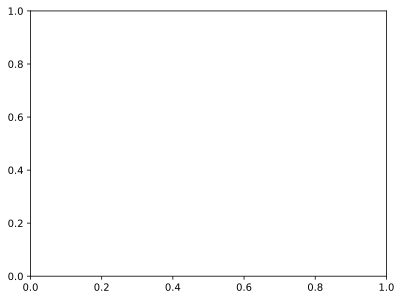

In [62]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


Replot data above

In [16]:
signs = [-1, -1, 1, 1] # whether the period occurs at the max (1) or min (-1)
opt_fit_index = 0

In [17]:
# saved_files = [
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00165_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00166_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00167_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00168_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00169_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00170_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00171_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00172_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00173_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00174_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00175_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00176_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00186_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00187_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00188_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00189_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00190_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00191_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00192_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00193_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00194_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00195_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00196_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00197_rabi_EgGf_freqlen_chevron_qubit21.h5',
#    's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00198_rabi_EgGf_freqlen_chevron_qubit21.h5',
# ]

gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)
opt_lens = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())

    # if file_name != '00013_rabi_EgGf_freqlen_chevron_qubit21.h5': continue
    fitparams=[None, 1/temp_data['lenpts'][-1], None, None]

    data = rabiEgGfFreqLenChevron.analyze(data=temp_data, fitparams=fitparams)
    plot_freqs, plot_lens = rabiEgGfFreqLenChevron.display(data=data, fit=True, signs=signs)

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    print('plot len', plot_lens[opt_fit_index])
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = plot_freqs[opt_fit_index]
    opt_lens[i_file] = plot_lens[opt_fit_index]

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal lens\n', opt_lens)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_lens))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_lens, '.-')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.show()

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


### Alternative: fine gain vs freq sweep setup

In [ ]:
npts = 15

gain_sweep = np.linspace(14000, 18500, npts) # Q3/Q1
# gain_sweep = np.linspace(5000, 30000, npts) # Q2/Q1
print('gain_sweep\n', gain_sweep)

len_approx_gains = 1.5*np.linspace(0.350, 0.250, npts) # Q3/Q1
# len_approx_gains = 1.5*np.linspace(1.00, 0.300, npts) # Q2/Q1
print('max len for each gain (us)\n', len_approx_gains)

freq_approx_gains = np.linspace(5148.0, 5145.0, npts) # approx freq for each gain # Q3/Q1
# freq_approx_gains = np.linspace(5887.0, 5883, npts) # approx freq for each gain # Q2/Q1

print('approx freq for each gain\n', freq_approx_gains)
print('qubits', qubits)

opt_lens = len_approx_gains/1.5
opt_freqs = []
saved_files = []
save_files = True

In [128]:
len_approx_gains = 1.5*np.array(opt_lens)
freq_approx_gains = np.array(opt_freqs)
saved_files = []

In [130]:
for gain, stop_len, approx_freq in zip(gain_sweep, len_approx_gains, freq_approx_gains):
    # if gain < 27900: continue
    print('gain', int(gain), 'stop_len', stop_len, 'approx freq', approx_freq)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 2.5 # MHz
    npts_f = 20
    # npts_f = 60

    # start_len = stop_len/1.5
    # span_len = 0
    # expts_len = 1

    start_len = 0
    span_len = stop_len
    expts_len = 15

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=approx_freq - 0.5*span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f+1, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=span_len/npts_len, # [us]
        expts_len=expts_len,
        gain=int(gain),
        reps=1000,
        # reps=2000,
        # reps=10,
        pulse_type='flat_top',
        measure_f=None,
        post_process=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    success = False
    while not success:
        try:
            rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
            success = True
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(rabiEgGfFreqLenChevron.save_data())
    
    plt.figure(figsize=(9, 8))
    data = rabiEgGfFreqLenChevron.data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    opt_freqs.append((freq_max_amp_qA + freq_max_amp_qB)/2)
    print('opt freq', opt_freqs[-1])

gain 15088 stop_len 0.44879889395723266 approx freq 5146.504052659203


  0%|          | 0/21 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(saved_files)

In [ ]:
print('gain sweep\n', gain_sweep.tolist())
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


In [65]:
['S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00086_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00087_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00088_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00089_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00090_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00091_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00092_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00093_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00094_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00095_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00096_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00097_rabi_EgGf_freqlen_chevron_qubit31.h5', 'S:\\Connie\\experiments\\qramLL_4QR2\\data\\data_240617\\00098_rabi_EgGf_freqlen_chevron_qubit31.h5']
gain_sweep = [0]*len(saved_files)
opt_freqs = [0]*len(saved_files)

In [ ]:
# going through files again to get opt lens, freqs
for i_file, saved_file in enumerate(saved_files):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    rabiEgGfLenChevron = meas.EgGfFreqLenChevronExperiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, file_name)
    rabiEgGfLenChevron.cfg.expt = AttrDict(attrs['config']['expt'])
    # print(temp_data.keys())
    
    plt.figure(figsize=(9, 8))
    data = temp_data
    plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]
    # plot_len = rabiEgGfFreqLenChevron.cfg.device.qubit.pulses.pi_EgGf.sigma[qubits[0]]
    len_ind = np.argmin(np.abs(data['lenpts']-plot_len))
    
    amps_freq_cut_qA = data['amps'][0][:, len_ind]
    amps_freq_cut_qB = data['amps'][1][:, len_ind]
    p_ampsA, pCov_ampsA = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qA)
    p_ampsB, pCov_ampsB = meas.fitting.fitquadratic(data['freqpts'], amps_freq_cut_qB)
    fit_amps_freq_cut_qA = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsA)
    fit_amps_freq_cut_qB = meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB)
    freq_max_amp_qA = data['freqpts'][np.argmax(fit_amps_freq_cut_qA)]
    freq_min_amp_qB = data['freqpts'][np.argmin(fit_amps_freq_cut_qB)]
    print('QA freq with max amp', freq_max_amp_qA)
    print('QB freq with min amp', freq_min_amp_qB)
    plt.suptitle(f"Cut through length {data['lenpts'][len_ind]:.3} us")
    plt.subplot(211, title=f'QA ({qubits[0]})')
    plt.plot(data['freqpts'], amps_freq_cut_qA, '.-', label='qA', color=default_colors[0])
    plt.plot(data['freqpts'], fit_amps_freq_cut_qA, color=default_colors[0])
    plt.axvline(freq_max_amp_qA, color=default_colors[0], linestyle='--')
    plt.ylabel('Amplitude [ADC units]')
    
    plt.subplot(212, title=f'QB ({qubits[1]})')
    plt.plot(data['freqpts'], amps_freq_cut_qB, '.-', label='qB', color=default_colors[1])
    plt.plot(data['freqpts'], meas.fitting.quadraticfunc(data['freqpts'], *p_ampsB), color=default_colors[1])
    plt.axvline(freq_min_amp_qB, color=default_colors[1], linestyle='--')
    # plt.axvline(5890.45, color='r', linestyle='--')
    # plt.axvline(bad_ZZ_freq, color='r', linestyle='--')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Amplitude [ADC units]')
    plt.tight_layout()
    plt.show()

    print('gain', rabiEgGfLenChevron.cfg.expt.gain)
    print('plot freq', plot_freqs[opt_fit_index])
    
    gain_sweep[i_file] = rabiEgGfLenChevron.cfg.expt.gain
    opt_freqs[i_file] = (freq_max_amp_qA + freq_min_amp_qB)/2

In [ ]:
print('gain sweep\n', gain_sweep)
print('optimal freqs\n', opt_freqs)
print('saved files\n', saved_files)

print(len(gain_sweep))
print(len(opt_freqs))

plt.plot(gain_sweep, opt_freqs, '.-')
plt.xlabel('Gain')
plt.ylabel('Frequecy (MHz)')
plt.show()


## [Auto3] Run again with length rabi and error amplification on selected frequencies

### Functions for fine calibration experiments

In [75]:
def run_swap_length_rabi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap length rabi --------")
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    lengthrabiEgGf.cfg = AttrDict(deepcopy(yaml_cfg))
    
    stop_len = opt_len*2
    start_len = 0
    span_len = stop_len - start_len
    npts_len = 101
    # npts_len = 50

    sweep2Q_q = qubits[0]
    lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq
    print('gain', lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'freq', lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        # reps=60,
        # loops=10,
        reps=1000 if not good_data else 3000,
        # loops=3,
        # post_process='threshold',
        post_process=None,
        singleshot_reps=20000,
        measure_f=None,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
        success = True
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_data:
        assert saved_files is not None
        saved_files.append(lengthrabiEgGf.save_data())
        print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    p, pcov = meas.fitting.get_best_fit(data, prefixes=['fitA', 'fitB'], check_measures=['amps'])
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360
    if p[2] < 0:
        pi_len = (1 / 2 - p[2] / 180) / 2 / p[1]
    else:
        pi_len = (3 / 2 - p[2] / 180) / 2 / p[1]

    lengthrabiEgGf.display(data=data, fit=True)
    # new_opt_len = pi_lens[opt_fit_index]
    new_opt_len = pi_len

    return new_opt_len

In [81]:
def run_swap_piminuspi(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap pi minus pi --------")
    piminuspi = meas.PiMinusPiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))

    piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    piminuspi.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
    piminuspi.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq

    span_f = 1.0
    # npts_f = 70
    npts_f = 30 if not good_data else 75

    piminuspi.cfg.expt = dict(
        start_N=0, # number gate repetitions
        # step_N=2,
        step_N=1,
        expts_N=10 if not good_data else 20,
        start_f=opt_freq-span_f/2,
        step_f=span_f/npts_f,
        expts_f=npts_f+1,

        reps=1000 if not good_data else 6000,
        loops=1,

        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        # singleshot_reps=5000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        readout_cool=False,
        n_init_readout=1,
        n_trig=1,
        # init_read_wait_us=5,
        init_read_wait_us=2,
        
        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )
    piminuspi.cfg.device.readout.gain[1] = 1e-4

    print(piminuspi.cfg)
    try:
        piminuspi.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    data = piminuspi.data
    piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)

    if save_data:
        assert saved_files is not None
        saved_files.append(piminuspi.save_data())
        print('Saved', saved_files[-1])

    return data['best_freq']

In [82]:
def run_swap_error_amp(sweep2Q_q, yaml_cfg, gain, opt_len, opt_freq, save_data=True, saved_files=None, good_data=False):
    print(f"-------- swap error amplification --------")
    npulsecalib = meas.NPulseEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptEgGfQ{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))

    npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_len
    npulsecalib.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freq

    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=10 if not good_data else 15,
        reps=2000,
        loops=10,
        # reps=1000,
        # loops=2,

        pulse_type='flat_top',
        # post_process='threshold',
        post_process='scale',
        singleshot_reps=15000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,

        full_mux_expt=full_mux_expt,
        resonator_reset=[0, 2, 3],
    )

    print(npulsecalib.cfg)
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    if save_data:
        assert saved_files is not None
        saved_files.append(npulsecalib.save_data())
        print('Saved', saved_files[-1])

    data = npulsecalib.data
    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)

    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['amps'])

    if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
    else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
    if use_q == qDrive: sign = 1
    else: sign = -1
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - sign*angle_err)/180
    new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] / amp_ratio

    print('pi len precise', new_opt_len, f'adjustment ratio {amp_ratio} from Q{use_q}')
    return new_opt_len

### Start the fine calibration

#### Q3/Q1

In [97]:
qubits = [3, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|1>|1>' # for everything else
wrong_init_state = '|0>|1>'
setup_ZZ = 0 # for the amp rabi chevron
# measure_qubits = [qubits[0], qubits[1], 2]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [98]:
do_length_rabi = do_piminuspi = do_error_amp = False

do_length_rabi = True
do_piminuspi = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

save_files = True

good_data = False

full_mux_expt = True

In [99]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [100]:
# Input the freqs fitted from the amp rabi chevron and the gain sweep used in that chevron

fit_gain_sweep = [7000, 8250, 9500, 10750, 12000, 13250, 14500, 15750, 17000, 18250, 19500, 20750, 22000, 23250, 24500, 25750, 27000, 28250, 29500, 30750]
fit_freqs = [5147.908620853933, 5147.446833987711, 5146.894169693789, 5146.250627972168, 5145.6854219684565, 5144.861819906756, 5143.957537110906, 5142.972573580907, 5141.9069293167595, 5140.760604318461, 5139.533598586016, 5138.22591211942, 5136.837544918675, 5135.368496983781, 5133.818768314738, 5132.188358911546, 5130.477268774204, 5128.685497902714, 5126.813046297074, 5124.859913957285]


# Fit those to a quadratic function and use this to extrapolate frequencies for the gain sweep of the actual experiment
fitparams = [fit_gain_sweep[0], fit_freqs[0], fit_freqs[-1] - fit_freqs[0]]
p, pCov = meas.fitting.fitquadratic(fit_gain_sweep, fit_freqs, fitparams=fitparams)

In [101]:
npts = 35

gain_sweep = np.linspace(7000, 32000, npts)
print('gain_sweep\n', gain_sweep)

# Guess the approximate lengths corresponding to the gain sweep
opt_lens = np.linspace(0.8, 0.200, npts)
print('approx len for each gain (us)\n', opt_lens)

# Calculate the approximate frequencies corresponding to the gain sweep using the fit 
opt_freqs = meas.fitting.quadraticfunc(gain_sweep, *p)
print('approx freq for each gain\n', opt_freqs.tolist())

print('qubits', qubits)

save_files = True
new_opt_lens = []
new_opt_lens2 = []
new_opt_freqs = []

saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

gain_sweep
 [ 7000.          7735.29411765  8470.58823529  9205.88235294
  9941.17647059 10676.47058824 11411.76470588 12147.05882353
 12882.35294118 13617.64705882 14352.94117647 15088.23529412
 15823.52941176 16558.82352941 17294.11764706 18029.41176471
 18764.70588235 19500.         20235.29411765 20970.58823529
 21705.88235294 22441.17647059 23176.47058824 23911.76470588
 24647.05882353 25382.35294118 26117.64705882 26852.94117647
 27588.23529412 28323.52941176 29058.82352941 29794.11764706
 30529.41176471 31264.70588235 32000.        ]
approx len for each gain (us)
 [0.8        0.78235294 0.76470588 0.74705882 0.72941176 0.71176471
 0.69411765 0.67647059 0.65882353 0.64117647 0.62352941 0.60588235
 0.58823529 0.57058824 0.55294118 0.53529412 0.51764706 0.5
 0.48235294 0.46470588 0.44705882 0.42941176 0.41176471 0.39411765
 0.37647059 0.35882353 0.34117647 0.32352941 0.30588235 0.28823529
 0.27058824 0.25294118 0.23529412 0.21764706 0.2       ]
approx freq for each gain
 [5147.9317

In [ ]:
# save_files = True
# new_opt_lens = []
# new_opt_lens2 = []
# new_opt_freqs = []

# saved_files_lengthrabi = []
# saved_files_piminuspi = []
# saved_files_error_amp = []

# # opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
# signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

# opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

# gain_sweep = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.gain[qubits[0]]]
# opt_lens = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits[0]]]
# opt_freqs = [yaml_cfg.device.qubit.f_EgGf_Q[qubits[0]]]

In [102]:
# signs = [1, -1, -1, 1] # whether the period occurs at the max (1) or min (-1)
# opt_fit_index = 1

if not save_files: print('WARNING: NOT SAVING FILES!')
for i_gain, gain in enumerate(gain_sweep):
    # if i_gain != 7 and i_gain != 12: continue 
    # if gain < 15822: continue
    # if i_gain not in [3]: continue

    override = False

    print(f'----------- STARTING GAIN {gain} -----------')
    pi_len = opt_lens[i_gain]
    pi_freq = opt_freqs[i_gain]

    # ----- Length rabi ----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_len = yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
    if do_length_rabi and not override:
        pi_len = run_swap_length_rabi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_lengthrabi, good_data=good_data)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens) > i_gain:
            new_opt_lens[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from length rabi', pi_len)
        else:
            new_opt_lens.append(pi_len)
            print(f'for gain {gain} added swap pi len from length rabi', pi_len)
    override = False

    # ----- Pi minus pi----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_freq = yaml_cfg.device.qubit.f_EgGf_Q[qDrive]
    if do_piminuspi and not override:
        pi_freq = run_swap_piminuspi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_piminuspi, good_data=good_data)
        yaml_cfg.device.qubit.f_EgGf_Q[qDrive] = pi_freq
        if len(new_opt_freqs) > i_gain:
            new_opt_freqs[i_gain] = pi_freq
            print(f'for gain {gain} updated swap pi freq from pi minus pi', pi_freq)
        else:
            new_opt_freqs.append(pi_freq)
            print(f'for gain {gain} added swap pi freq from pi minus pi', pi_freq)
    override = False

    # ----- Error amplification ----- #
    if do_error_amp and not override:
        print('using opt freq', pi_freq)
        pi_len = run_swap_error_amp(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_error_amp, good_data=good_data)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens2) > i_gain:
            new_opt_lens2[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from error amplification', pi_len)
        else:
            new_opt_lens2.append(pi_len)
            print(f'for gain {gain} added swap pi len from error amplification', pi_len)
    override = False

----------- STARTING GAIN 7000.0 -----------
-------- swap length rabi --------
gain 7000 freq 5147.931720795898


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00075_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00075_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 1 0.06169059393980484
Pi length from amps data (qubit A) [us]: 0.4737868781203163
	Pi/2 length from avgq data (qubit A) [us]: 0.23689343906015814
	Decay time [us]: 21.591767276783386
Pi length from avgq data (qubit A) [us]: 0.594059405940594
	Pi/2 length from avgq data (qubit A) [us]: 0.297029702970297
	Decay time [us]: 1.5841584158415842
Pi length from amps data (qubit B) [us]: 0.47200285304219325
	Pi/2 length from avgq data (qubit B) [us]: 0.23600142652109662
	Decay tim

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.8794168500122 	 angle (deg): 0.0 	 threshold ge: 157.65710690648837
Qubit  (1)
ge fidelity (%): 2.088710358468343 	 angle (deg): 0.0 	 threshold ge: 48.310279617592265


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.24737575122322134. Instead init to 0.12368787561161067
Fit best freq (qA) 5147.99318202018 which is 0.061461224281629256 away from old freq 5147.931720795898
Best freq from pi/-pi on Q3 5147.99318202018
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.0968771251006228. Instead init to 0.0484385625503114
Fit best freq (qA) 5148.169185130601 which is 0.23746433470296324 away from old freq 5147.931720795898
Best freq from pi/-pi on Q1 5148.169185130601
best 0 0.0443093216701433
Saving S:\QRAM\qram_4QR2\data\data_241025\00080_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00080_PiMinusPiEgGfExptQ31.h5
for gain 7000.0 added swap pi freq from pi minus pi 5147.99318202018
using opt freq 5147.99318202018
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.89999999999

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 83.82000000000002 	 angle (deg): 0.0 	 threshold ge: 162.0401054783253
Qubit  (1)
ge fidelity (%): 57.24 	 angle (deg): 0.0 	 threshold ge: 306.6406091639821


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00074_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00074_NPulseExptEgGfQ31.h5
[ 0.4779223   0.98328719 46.80568712]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[175.74567348976078, 0.0, 10]
[ 0.58612549 -0.97052661 25.56043081]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[317.1143407497712, 0.0, 10]
From QA: adjust length to 0.4745954286407827
	adjust ratio 0.9945372933616018

From QB: adjust length to 0.4745616011735297
	adjust ratio 0.9946081854810651
best 0 inf
pi len precise 0.47200285304219325 adjustment ratio 1.0 from Q1
for gain 7000.0 added swap pi len from error amplification 0.47200285304219325
----------- STARTING GAIN 7735.294117647059 -----------
-------- swap length rabi --------
gain 7735 freq 5147.671589641677


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00076_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00076_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 1 0.012896917817094053
Pi length from amps data (qubit A) [us]: 0.4320913639052098
	Pi/2 length from avgq data (qubit A) [us]: 0.2160456819526049
	Decay time [us]: 14.106881132398334
Pi length from avgq data (qubit A) [us]: 0.5809551543389633
	Pi/2 length from avgq data (qubit A) [us]: 0.29047757716948164
	Decay time [us]: 1.549213744903902
Pi length from amps data (qubit B) [us]: 0.4462483335766198
	Pi/2 length from avgq data (qubit B) [us]: 0.2231241667883099
	Decay tim

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 82.03947463164212 	 angle (deg): 0.0 	 threshold ge: 159.01070652765765
Qubit  (1)
ge fidelity (%): 2.42 	 angle (deg): 0.0 	 threshold ge: 82.88375581093764


  0%|          | 0/10 [00:00<?, ?it/s]

 s:\Connie\experiments\qram_tprocv1_expts\experiments\two_qubit\length_rabi_EgGf.py: 2788

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.22081938255284636. Instead init to 0.11040969127642318
Fit best freq (qA) 5147.6827919025 which is 0.011202260822756216 away from old freq 5147.671589641677
Best freq from pi/-pi on Q3 5147.6827919025
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.07462684883262954. Instead init to 0.03731342441631477
Fit best freq (qA) 5147.689297355942 which is 0.01770771426436113 away from old freq 5147.671589641677
Best freq from pi/-pi on Q1 5147.689297355942
best 0 0.04661369926438431
Saving S:\QRAM\qram_4QR2\data\data_241025\00081_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00081_PiMinusPiEgGfExptQ31.h5
for gain 7735.294117647059 added swap pi freq from pi minus pi 5147.6827919025
using opt freq 5147.6827919025
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.8

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.8993488454786 	 angle (deg): 0.0 	 threshold ge: 164.68758110153064
Qubit  (1)
ge fidelity (%): 52.69333333333335 	 angle (deg): 0.0 	 threshold ge: 317.1823328068115


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00075_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00075_NPulseExptEgGfQ31.h5
[ 0.51255894 -3.57069971 11.13420449]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.9536295675278, 0.0, 10]
[0.69154567 2.35657714 7.80806541]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[330.9628461337509, 0.0, 10]
From QA: adjust length to 0.4375681967341979
	adjust ratio 1.019837220591456

From QB: adjust length to 0.4404815077294232
	adjust ratio 1.0130920952321545
best 0 inf
pi len precise 0.4462483335766198 adjustment ratio 1.0 from Q1
for gain 7735.294117647059 added swap pi len from error amplification 0.4462483335766198
----------- STARTING GAIN 8470.588235294117 -----------
-------- swap length rabi --------
gain 8470 freq 5147.382359692795


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00077_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00077_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.029924742177384202
Pi length from amps data (qubit A) [us]: 0.3935770171685791
	Pi/2 length from avgq data (qubit A) [us]: 0.19678850858428956
	Decay time [us]: 6.465797711517277
Pi length from avgq data (qubit A) [us]: 0.5678509027373326
	Pi/2 length from avgq data (qubit A) [us]: 0.2839254513686663
	Decay time [us]: 1.5142690739662203
Pi length from amps data (qubit B) [us]: 0.39828993188519957
	Pi/2 length from avgq data (qubit B) [us]: 0.19914496594259978
	Decay t

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.49939329288615 	 angle (deg): 0.0 	 threshold ge: 161.96292744663015
Qubit  (1)
ge fidelity (%): 2.7599999999999514 	 angle (deg): 0.0 	 threshold ge: 88.37785670166745


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2361794630228345. Instead init to 0.11808973151141725
Fit best freq (qA) 5147.369818306699 which is -0.012541386096017959 away from old freq 5147.382359692795
Best freq from pi/-pi on Q3 5147.369818306699
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.09962341105279314. Instead init to 0.04981170552639657
Fit best freq (qA) 5147.347639540882 which is -0.03472015191346145 away from old freq 5147.382359692795
Best freq from pi/-pi on Q1 5147.347639540882
best 0 0.0476517306195593
Saving S:\QRAM\qram_4QR2\data\data_241025\00082_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00082_PiMinusPiEgGfExptQ31.h5
for gain 8470.588235294117 added swap pi freq from pi minus pi 5147.369818306699
using opt freq 5147.369818306699
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.12607284930104 	 angle (deg): 0.0 	 threshold ge: 167.50972988051328
Qubit  (1)
ge fidelity (%): 55.42000000000002 	 angle (deg): 0.0 	 threshold ge: 311.7390258231403


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00076_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00076_NPulseExptEgGfQ31.h5
[ 0.50530439  0.82578173 14.16418376]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[179.6000261734069, 0.0, 10]
[ 0.60804069 -0.76478207 10.78109641]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[319.92318950866445, 0.0, 10]
From QA: adjust length to 0.39539094282703197
	adjust ratio 0.9954123236979499

From QB: adjust length to 0.3952563782337439
	adjust ratio 0.9957512107137418
best 0 inf
pi len precise 0.3935770171685791 adjustment ratio 1.0 from Q1
for gain 8470.588235294117 added swap pi len from error amplification 0.3935770171685791
----------- STARTING GAIN 9205.882352941177 -----------
-------- swap length rabi --------
gain 9205 freq 5147.064030949251


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00078_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00078_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.03389353538785265
Pi length from amps data (qubit A) [us]: 0.3661172064234872
	Pi/2 length from avgq data (qubit A) [us]: 0.1830586032117436
	Decay time [us]: 6.35535882230171
Pi length from avgq data (qubit A) [us]: 0.5547466511357019
	Pi/2 length from avgq data (qubit A) [us]: 0.27737332556785094
	Decay time [us]: 1.4793244030285382
Pi length from amps data (qubit B) [us]: 0.37001861136435815
	Pi/2 length from avgq data (qubit B) [us]: 0.18500930568217908
	Decay tim

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.41921372535947 	 angle (deg): 0.0 	 threshold ge: 163.33340284340142
Qubit  (1)
ge fidelity (%): 1.7533333333333068 	 angle (deg): 0.0 	 threshold ge: 111.00348250533938


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2906995687180247. Instead init to 0.14534978435901236
Fit best freq (qA) 5147.0095936948965 which is -0.054437254354525066 away from old freq 5147.064030949251
Best freq from pi/-pi on Q3 5147.0095936948965
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.09577776848147873. Instead init to 0.047888884240739366
Fit best freq (qA) 5146.727550037072 which is -0.33648091217855836 away from old freq 5147.064030949251
Best freq from pi/-pi on Q1 5146.727550037072
best 0 0.032050463803614676
Saving S:\QRAM\qram_4QR2\data\data_241025\00083_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00083_PiMinusPiEgGfExptQ31.h5
for gain 9205.882352941177 added swap pi freq from pi minus pi 5147.0095936948965
using opt freq 5147.0095936948965
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.368233

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 79.1466666666667 	 angle (deg): 0.0 	 threshold ge: 166.38829778758858
Qubit  (1)
ge fidelity (%): 56.81333333333336 	 angle (deg): 0.0 	 threshold ge: 313.0461750950032


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00077_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00077_NPulseExptEgGfQ31.h5
[ 0.51078817 -0.13297444 22.59406829]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[179.17048599871947, 0.0, 10]
[0.61872228 0.07848097 4.27710211]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[322.63131032  11.29473155  99.99470441]
From QA: adjust length to 0.36584693812781033
	adjust ratio 1.0007387469116455

From QB: adjust length to 0.36595764691461535
	adjust ratio 1.0004360053962995
best 1 20.037085225236844
pi len precise 0.3445003248172285 adjustment ratio 1.0627485086341424 from Q1
for gain 9205.882352941177 added swap pi len from error amplification 0.3445003248172285
----------- STARTING GAIN 9941.176470588234 -----------
-------- swap length rabi --------
gain 9941 freq 5146.716603411045


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00079_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00079_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.07906549151280665
Pi length from amps data (qubit A) [us]: 0.3392260760342203
	Pi/2 length from avgq data (qubit A) [us]: 0.16961303801711014
	Decay time [us]: 15.599778627571327
Pi length from avgq data (qubit A) [us]: 0.5416423995340711
	Pi/2 length from avgq data (qubit A) [us]: 0.27082119976703556
	Decay time [us]: 1.4443797320908562
Pi length from amps data (qubit B) [us]: 0.3378683053100482
	Pi/2 length from avgq data (qubit B) [us]: 0.1689341526550241
	Decay ti

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 77.75263373113765 	 angle (deg): 0.0 	 threshold ge: 166.82734042364322
Qubit  (1)
ge fidelity (%): 1.7799999999999927 	 angle (deg): 0.0 	 threshold ge: 93.68743782452331


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.25919104024755385. Instead init to 0.12959552012377692
Fit best freq (qA) 5146.649493923319 which is -0.06710948772615666 away from old freq 5146.716603411045
Best freq from pi/-pi on Q3 5146.649493923319
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.0284598732985829. Instead init to 0.01422993664929145
Fit best freq (qA) 5146.605016570355 which is -0.1115868406905065 away from old freq 5146.716603411045
Best freq from pi/-pi on Q1 5146.605016570355
best 0 0.11145008630537201
Saving S:\QRAM\qram_4QR2\data\data_241025\00084_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00084_PiMinusPiEgGfExptQ31.h5
for gain 9941.176470588234 added swap pi freq from pi minus pi 5146.649493923319
using opt freq 5146.649493923319
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.04000000000003 	 angle (deg): 0.0 	 threshold ge: 164.33482201254495
Qubit  (1)
ge fidelity (%): 57.37999999999999 	 angle (deg): 0.0 	 threshold ge: 311.75936185858046


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00078_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00078_NPulseExptEgGfQ31.h5
[ 0.5090761   0.89079273 10.96748414]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[179.90611330778876, 0.0, 10]
[ 0.63000911 -1.09760761  5.42217994]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[323.0538681132258, 0.0, 10]
From QA: adjust length to 0.3409132038242258
	adjust ratio 0.995051151521619

From QB: adjust length to 0.34130730656539354
	adjust ratio 0.9939021799676167
best 0 inf
pi len precise 0.3392260760342203 adjustment ratio 1.0 from Q1
for gain 9941.176470588234 added swap pi len from error amplification 0.3392260760342203
----------- STARTING GAIN 10676.470588235294 -----------
-------- swap length rabi --------
gain 10676 freq 5146.340077078177


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00080_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00080_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04124530823731055
Pi length from amps data (qubit A) [us]: 0.3197021004429004
	Pi/2 length from avgq data (qubit A) [us]: 0.1598510502214502
	Decay time [us]: 8.317544522094444
Pi length from avgq data (qubit A) [us]: 0.5285381479324404
	Pi/2 length from avgq data (qubit A) [us]: 0.2642690739662202
	Decay time [us]: 1.4094350611531743
Pi length from amps data (qubit B) [us]: 0.7156265907773681
	Pi/2 length from avgq data (qubit B) [us]: 0.35781329538868406
	Decay time

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.66586394648532 	 angle (deg): 0.0 	 threshold ge: 161.62173185845222
Qubit  (1)
ge fidelity (%): 2.22278418561237 	 angle (deg): 0.0 	 threshold ge: 78.23178487487836


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.23374145063571494. Instead init to 0.11687072531785747
Fit best freq (qA) 5146.2282856729535 which is -0.11179140522381203 away from old freq 5146.340077078177
Best freq from pi/-pi on Q3 5146.2282856729535
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.01693274348655997. Instead init to 0.008466371743279985
Fit best freq (qA) 5146.3262410831 which is -0.013835995076988183 away from old freq 5146.340077078177
Best freq from pi/-pi on Q1 5146.3262410831
best 0 0.1117739679434497
Saving S:\QRAM\qram_4QR2\data\data_241025\00085_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00085_PiMinusPiEgGfExptQ31.h5
for gain 10676.470588235294 added swap pi freq from pi minus pi 5146.2282856729535
using opt freq 5146.2282856729535
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.13261017401157 	 angle (deg): 0.0 	 threshold ge: 166.14351081065962
Qubit  (1)
ge fidelity (%): 54.87333333333333 	 angle (deg): 0.0 	 threshold ge: 311.67252720028137


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00079_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00079_NPulseExptEgGfQ31.h5
[ 0.52459621 -0.85452495 63.1410713 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[180.03308114233113, 0.0, 10]
[0.77048356 0.74975498 6.04265375]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[338.0973089008826, 0.0, 10]
From QA: adjust length to 0.31819153044156046
	adjust ratio 1.004747360808893

From QB: adjust length to 0.3183759672932947
	adjust ratio 1.0041653054433723
best 0 inf
pi len precise 0.3197021004429004 adjustment ratio 1.0 from Q1
for gain 10676.470588235294 added swap pi len from error amplification 0.3197021004429004
----------- STARTING GAIN 11411.764705882353 -----------
-------- swap length rabi --------
gain 11411 freq 5145.934451950648


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00081_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00081_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.0784243641109308
Pi length from amps data (qubit A) [us]: 0.2961380879096939
	Pi/2 length from avgq data (qubit A) [us]: 0.14806904395484696
	Decay time [us]: 14.959694148323527
Pi length from avgq data (qubit A) [us]: 0.5154338963308096
	Pi/2 length from avgq data (qubit A) [us]: 0.2577169481654048
	Decay time [us]: 1.3744903902154921
Pi length from amps data (qubit B) [us]: 0.2861253568737148
	Pi/2 length from avgq data (qubit B) [us]: 0.1430626784368574
	Decay time

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.43920794719645 	 angle (deg): 0.0 	 threshold ge: 163.74769125144877
Qubit  (1)
ge fidelity (%): 2.5430762050803524 	 angle (deg): 0.0 	 threshold ge: 73.5013061459199


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.25682770990851006. Instead init to 0.12841385495425503
Fit best freq (qA) 5145.807622120507 which is -0.12682983014019555 away from old freq 5145.934451950648
Best freq from pi/-pi on Q3 5145.807622120507
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.04703991956324116. Instead init to 0.02351995978162058
Fit best freq (qA) 5145.813280134272 which is -0.12117181637586327 away from old freq 5145.934451950648
Best freq from pi/-pi on Q1 5145.813280134272
best 0 0.1160648859839535
Saving S:\QRAM\qram_4QR2\data\data_241025\00086_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00086_PiMinusPiEgGfExptQ31.h5
for gain 11411.764705882353 added swap pi freq from pi minus pi 5145.807622120507
using opt freq 5145.807622120507
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.368233333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.06584394515188 	 angle (deg): 0.0 	 threshold ge: 161.82428041081636
Qubit  (1)
ge fidelity (%): 54.22 	 angle (deg): 0.0 	 threshold ge: 310.08521587109266


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00080_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00080_NPulseExptEgGfQ31.h5
[0.50140719 1.64347432 8.58578333]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[180.01894284513796, 0.0, 10]
[ 0.77355457 -0.65935105 11.91978892]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[337.2751796017767, 0.0, 10]
From QA: adjust length to 0.2988668657886043
	adjust ratio 0.9908695871263278

From QB: adjust length to 0.29722684810369093
	adjust ratio 0.996336938601128
best 0 inf
pi len precise 0.2961380879096939 adjustment ratio 1.0 from Q1
for gain 11411.764705882353 added swap pi len from error amplification 0.2961380879096939
----------- STARTING GAIN 12147.058823529413 -----------
-------- swap length rabi --------
gain 12147 freq 5145.499728028457


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00082_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00082_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.03086589728861025
Pi length from amps data (qubit A) [us]: 0.2805061186736545
	Pi/2 length from avgq data (qubit A) [us]: 0.14025305933682725
	Decay time [us]: 5.695408108590071
Pi length from avgq data (qubit A) [us]: 0.5023296447291788
	Pi/2 length from avgq data (qubit A) [us]: 0.2511648223645894
	Decay time [us]: 1.3395457192778102
Pi length from amps data (qubit B) [us]: 8.204763608797972
	Pi/2 length from avgq data (qubit B) [us]: 4.102381804398986
	Decay time [

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.66666666666666 	 angle (deg): 0.0 	 threshold ge: 164.1286970926037
Qubit  (1)
ge fidelity (%): 3.11685090117117 	 angle (deg): 0.0 	 threshold ge: 69.49984084139344


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.20289022333587634. Instead init to 0.10144511166793817
Fit best freq (qA) 5145.343359864123 which is -0.15636816433379863 away from old freq 5145.499728028457
Best freq from pi/-pi on Q3 5145.343359864123
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.17958376086315414. Instead init to 0.08979188043157707
Fit best freq (qA) 5145.127150809775 which is -0.37257721868172666 away from old freq 5145.499728028457
Best freq from pi/-pi on Q1 5145.127150809775
best 0 0.15801675996518535
Saving S:\QRAM\qram_4QR2\data\data_241025\00087_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00087_PiMinusPiEgGfExptQ31.h5
for gain 12147.058823529413 added swap pi freq from pi minus pi 5145.343359864123
using opt freq 5145.343359864123
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.36823333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.70000000000002 	 angle (deg): 0.0 	 threshold ge: 167.82539873824916
Qubit  (1)
ge fidelity (%): 55.13174167166702 	 angle (deg): 0.0 	 threshold ge: 311.1832235270679


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00081_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00081_NPulseExptEgGfQ31.h5
[0.50603718 1.07937385 5.09622698]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[181.43940352328735, 0.0, 10]
[ 0.75545501 -0.96739438  4.25927014]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[334.87667533884985, 0.0, 10]
From QA: adjust length to 0.28219832697186886
	adjust ratio 0.9940034786301797

From QB: adjust length to 0.2820218204697158
	adjust ratio 0.9946255867948911
best 0 inf
pi len precise 0.2805061186736545 adjustment ratio 1.0 from Q1
for gain 12147.058823529413 added swap pi len from error amplification 0.2805061186736545
----------- STARTING GAIN 12882.35294117647 -----------
-------- swap length rabi --------
gain 12882 freq 5145.035905311605


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00083_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00083_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.08121760714139317
Pi length from amps data (qubit A) [us]: 0.2636938615611933
	Pi/2 length from avgq data (qubit A) [us]: 0.13184693078059664
	Decay time [us]: 12.213958332641555
Pi length from avgq data (qubit A) [us]: 0.489225393127548
	Pi/2 length from avgq data (qubit A) [us]: 0.244612696563774
	Decay time [us]: 1.304601048340128
Pi length from amps data (qubit B) [us]: 0.26862745496251744
	Pi/2 length from avgq data (qubit B) [us]: 0.13431372748125872
	Decay time

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.47924039380405 	 angle (deg): 0.0 	 threshold ge: 168.612335516065
Qubit  (1)
ge fidelity (%): 2.0902011245194196 	 angle (deg): 0.0 	 threshold ge: 65.57620738351389


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2657016362740509. Instead init to 0.13285081813702546
Fit best freq (qA) 5144.862303940162 which is -0.1736013714435103 away from old freq 5145.035905311605
Best freq from pi/-pi on Q3 5144.862303940162
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.03634209654682929. Instead init to 0.018171048273414644
Fit best freq (qA) 5144.89514907717 which is -0.14075623443568475 away from old freq 5145.035905311605
Best freq from pi/-pi on Q1 5144.89514907717
best 1 0.17212446105190235
Saving S:\QRAM\qram_4QR2\data\data_241025\00088_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00088_PiMinusPiEgGfExptQ31.h5
for gain 12882.35294117647 added swap pi freq from pi minus pi 5144.89514907717
using opt freq 5144.89514907717
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -2

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.74666666666666 	 angle (deg): 0.0 	 threshold ge: 161.20431428860567
Qubit  (1)
ge fidelity (%): 55.56000000000001 	 angle (deg): 0.0 	 threshold ge: 310.2925583412393


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00082_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00082_NPulseExptEgGfQ31.h5
[ 0.48643921  3.04605053 10.8048969 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[180.1166604228078, 0.0, 10]
[ 0.66226697 -1.39877283 18.49593242]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[326.6938163555467, 0.0, 10]
From QA: adjust length to 0.2682330359006877
	adjust ratio 0.9830774970567943

From QB: adjust length to 0.2657590646681351
	adjust ratio 0.9922290398277828
best 0 inf
pi len precise 0.2636938615611933 adjustment ratio 1.0 from Q1
for gain 12882.35294117647 added swap pi len from error amplification 0.2636938615611933
----------- STARTING GAIN 13617.647058823528 -----------
-------- swap length rabi --------
gain 13617 freq 5144.542983800091


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00084_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00084_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.07746967669330534
Pi length from amps data (qubit A) [us]: 0.25335798809866994
	Pi/2 length from avgq data (qubit A) [us]: 0.12667899404933497
	Decay time [us]: 13.261204839636406
Pi length from avgq data (qubit A) [us]: 0.47612114152591734
	Pi/2 length from avgq data (qubit A) [us]: 0.23806057076295867
	Decay time [us]: 1.269656377402446
Pi length from amps data (qubit B) [us]: 0.2715469043542701
	Pi/2 length from avgq data (qubit B) [us]: 0.13577345217713505
	Decay 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.79914438740362 	 angle (deg): 0.0 	 threshold ge: 166.21323807135346
Qubit  (1)
ge fidelity (%): 2.4599999999999844 	 angle (deg): 0.0 	 threshold ge: 96.67507030509297


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.3630348204096054. Instead init to 0.1815174102048027
Fit best freq (qA) 5144.340271588578 which is -0.20271221151324426 away from old freq 5144.542983800091
Best freq from pi/-pi on Q3 5144.340271588578
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.057584754275325986. Instead init to 0.028792377137662993
Fit best freq (qA) 5144.538874621837 which is -0.004109178254111612 away from old freq 5144.542983800091
Best freq from pi/-pi on Q1 5144.538874621837
best 0 0.06802577702465452
Saving S:\QRAM\qram_4QR2\data\data_241025\00089_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00089_PiMinusPiEgGfExptQ31.h5
for gain 13617.647058823528 added swap pi freq from pi minus pi 5144.340271588578
using opt freq 5144.340271588578
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 81.3666666666667 	 angle (deg): 0.0 	 threshold ge: 166.45086799639253
Qubit  (1)
ge fidelity (%): 56.29333333333334 	 angle (deg): 0.0 	 threshold ge: 307.1367696757441


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00083_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00083_NPulseExptEgGfQ31.h5
[0.48615996 1.81978827 4.24748946]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.2686547979222, 0.0, 10]
[ 0.68804835 -0.77868891  7.05185517]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[326.93028953310636, 0.0, 10]
From QA: adjust length to 0.2559455812392132
	adjust ratio 0.9898900651927067

From QB: adjust length to 0.2544587894126831
	adjust ratio 0.9956739505184558
best 0 inf
pi len precise 0.25335798809866994 adjustment ratio 1.0 from Q1
for gain 13617.647058823528 added swap pi len from error amplification 0.25335798809866994
----------- STARTING GAIN 14352.941176470587 -----------
-------- swap length rabi --------
gain 14352 freq 5144.020963493916


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00085_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00085_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.053673942333759585
Pi length from amps data (qubit A) [us]: 0.237356076571024
	Pi/2 length from avgq data (qubit A) [us]: 0.118678038285512
	Decay time [us]: 7.351119623824522
Pi length from avgq data (qubit A) [us]: 0.4630168899242866
	Pi/2 length from avgq data (qubit A) [us]: 0.2315084449621433
	Decay time [us]: 1.2347117064647641
Pi length from amps data (qubit B) [us]: 3.5142924877834743
	Pi/2 length from avgq data (qubit B) [us]: 1.7571462438917371
	Decay time [

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.87333333333333 	 angle (deg): 0.0 	 threshold ge: 159.6301923032287
Qubit  (1)
ge fidelity (%): 1.8233646687556948 	 angle (deg): 0.0 	 threshold ge: 67.16974552498131


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2793380938094408. Instead init to 0.1396690469047204
Fit best freq (qA) 5143.808568684189 which is -0.21239480972690217 away from old freq 5144.020963493916
Best freq from pi/-pi on Q3 5143.808568684189
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.03913169365315116. Instead init to 0.01956584682657558
Fit best freq (qA) 5143.829123776181 which is -0.19183971773418307 away from old freq 5144.020963493916
Best freq from pi/-pi on Q1 5143.829123776181
best 1 0.19304869410956388
Saving S:\QRAM\qram_4QR2\data\data_241025\00090_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00090_PiMinusPiEgGfExptQ31.h5
for gain 14352.941176470587 added swap pi freq from pi minus pi 5143.829123776181
using opt freq 5143.829123776181
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.83267106695997 	 angle (deg): 0.0 	 threshold ge: 163.35259202737294
Qubit  (1)
ge fidelity (%): 55.625397693179536 	 angle (deg): 0.0 	 threshold ge: 312.75125057441187


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00084_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00084_NPulseExptEgGfQ31.h5
[ 0.49440934  3.25281256 10.63263857]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.9542914516979, 0.0, 10]
[ 0.67362945 -2.4112417   8.95532564]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[324.76439323412455, 0.0, 10]
From QA: adjust length to 0.24172432048791337
	adjust ratio 0.9819288191272099

From QB: adjust length to 0.24057881924111352
	adjust ratio 0.9866042127887427
best 0 inf
pi len precise 0.237356076571024 adjustment ratio 1.0 from Q1
for gain 14352.941176470587 added swap pi len from error amplification 0.237356076571024
----------- STARTING GAIN 15088.235294117647 -----------
-------- swap length rabi --------
gain 15088 freq 5143.469844393078


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00086_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00086_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.08670899461309543
Pi length from amps data (qubit A) [us]: 0.22966955817886023
	Pi/2 length from avgq data (qubit A) [us]: 0.11483477908943011
	Decay time [us]: 13.446293778236885
Pi length from avgq data (qubit A) [us]: 0.44991263832265593
	Pi/2 length from avgq data (qubit A) [us]: 0.22495631916132797
	Decay time [us]: 1.1997670355270824
Pi length from amps data (qubit B) [us]: 0.23293219969582538
	Pi/2 length from avgq data (qubit B) [us]: 0.11646609984791269
	Deca

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 80.76000000000003 	 angle (deg): 0.0 	 threshold ge: 161.63140165992513
Qubit  (1)
ge fidelity (%): 2.4733333333333607 	 angle (deg): 0.0 	 threshold ge: 73.13379599949089


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2347107961824329. Instead init to 0.11735539809121645
Fit best freq (qA) 5143.212857950753 which is -0.2569864423257968 away from old freq 5143.469844393078
Best freq from pi/-pi on Q3 5143.212857950753
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.0761975218559288. Instead init to 0.0380987609279644
Fit best freq (qA) 5143.1227174717715 which is -0.34712692130688083 away from old freq 5143.469844393078
Best freq from pi/-pi on Q1 5143.1227174717715
best 0 0.11561639194161248
Saving S:\QRAM\qram_4QR2\data\data_241025\00091_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00091_PiMinusPiEgGfExptQ31.h5
for gain 15088.235294117647 added swap pi freq from pi minus pi 5143.212857950753
using opt freq 5143.212857950753
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 81.39943774029383 	 angle (deg): 0.0 	 threshold ge: 164.3788422369787
Qubit  (1)
ge fidelity (%): 55.013333333333335 	 angle (deg): 0.0 	 threshold ge: 307.5066404799482


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00085_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00085_NPulseExptEgGfQ31.h5
[0.49011599 2.09584528 3.42666911]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[175.7365685909303, 0.0, 10]
[ 0.74541704 -0.74930893  5.28900969]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[332.2508302293186, 0.0, 10]
From QA: adjust length to 0.23237523899659207
	adjust ratio 0.9883564151266069

From QB: adjust length to 0.23062962952290475
	adjust ratio 0.9958371725869283
best 0 inf
pi len precise 0.22966955817886023 adjustment ratio 1.0 from Q1
for gain 15088.235294117647 added swap pi len from error amplification 0.22966955817886023
----------- STARTING GAIN 15823.529411764706 -----------
-------- swap length rabi --------
gain 15823 freq 5142.88962649758


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00087_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00087_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05672794164584001
Pi length from amps data (qubit A) [us]: 0.21757555901250342
	Pi/2 length from avgq data (qubit A) [us]: 0.10878777950625171
	Decay time [us]: 7.723437807550742
Pi length from avgq data (qubit A) [us]: 0.436808386721025
	Pi/2 length from avgq data (qubit A) [us]: 0.2184041933605125
	Decay time [us]: 1.1648223645894
Pi length from amps data (qubit B) [us]: 0.22072969146597532
	Pi/2 length from avgq data (qubit B) [us]: 0.11036484573298766
	Decay time 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.0258141653888 	 angle (deg): 0.0 	 threshold ge: 163.42509738384376
Qubit  (1)
ge fidelity (%): 2.3066666666666458 	 angle (deg): 0.0 	 threshold ge: 103.19975332858495


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.29108218826395466. Instead init to 0.14554109413197733
Fit best freq (qA) 5142.648323761926 which is -0.24130273565424432 away from old freq 5142.88962649758
Best freq from pi/-pi on Q3 5142.648323761926
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.08506888867535792. Instead init to 0.04253444433767896
Fit best freq (qA) 5142.564017285258 which is -0.3256092123219787 away from old freq 5142.88962649758
Best freq from pi/-pi on Q1 5142.564017285258
best 0 0.05281458437539725
Saving S:\QRAM\qram_4QR2\data\data_241025\00092_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00092_PiMinusPiEgGfExptQ31.h5
for gain 15823.529411764706 added swap pi freq from pi minus pi 5142.648323761926
using opt freq 5142.648323761926
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.28000000000003 	 angle (deg): 0.0 	 threshold ge: 164.52474074336516
Qubit  (1)
ge fidelity (%): 54.63333333333333 	 angle (deg): 0.0 	 threshold ge: 305.61954689062384


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00086_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00086_NPulseExptEgGfQ31.h5
[0.44415761 3.02058171 8.71123379]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[169.86334191434122, 0.0, 10]
[ 0.72813386 -1.44040618 12.26037153]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[330.43879578476026, 0.0, 10]
From QA: adjust length to 0.2212890120231551
	adjust ratio 0.9832189905106399

From QB: adjust length to 0.21933069953824452
	adjust ratio 0.9919977434557214
best 0 inf
pi len precise 0.21757555901250342 adjustment ratio 1.0 from Q1
for gain 15823.529411764706 added swap pi len from error amplification 0.21757555901250342
----------- STARTING GAIN 16558.823529411762 -----------
-------- swap length rabi --------
gain 16558 freq 5142.280309807419


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00088_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00088_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.03814727200456602
Pi length from amps data (qubit A) [us]: 0.21082829572908218
	Pi/2 length from avgq data (qubit A) [us]: 0.10541414786454109
	Decay time [us]: 3.963150978433896
Pi length from avgq data (qubit A) [us]: 0.4237041351193942
	Pi/2 length from avgq data (qubit A) [us]: 0.2118520675596971
	Decay time [us]: 1.1298776936517179
Pi length from amps data (qubit B) [us]: 0.20593518262534952
	Pi/2 length from avgq data (qubit B) [us]: 0.10296759131267476
	Decay t

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.54666666666667 	 angle (deg): 0.0 	 threshold ge: 161.0157310922137
Qubit  (1)
ge fidelity (%): 1.3933333333333353 	 angle (deg): 0.0 	 threshold ge: 60.4124358707753


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.38391651529225973. Instead init to 0.19195825764612987
Fit best freq (qA) 5142.032496978786 which is -0.24781282863295928 away from old freq 5142.280309807419
Best freq from pi/-pi on Q3 5142.032496978786
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.05669136147302389. Instead init to 0.028345680736511943
Fit best freq (qA) 5141.997615530977 which is -0.2826942764422711 away from old freq 5142.280309807419
Best freq from pi/-pi on Q1 5141.997615530977
best 0 0.07971153739124118
Saving S:\QRAM\qram_4QR2\data\data_241025\00093_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00093_PiMinusPiEgGfExptQ31.h5
for gain 16558.823529411762 added swap pi freq from pi minus pi 5142.032496978786
using opt freq 5142.032496978786
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.36823333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.63333333333335 	 angle (deg): 0.0 	 threshold ge: 160.8219386702268
Qubit  (1)
ge fidelity (%): 56.04666666666665 	 angle (deg): 0.0 	 threshold ge: 305.4779349357417


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00087_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00087_NPulseExptEgGfQ31.h5
[0.44299195 3.07741659 7.22187024]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[168.10302416019067, 0.0, 10]
[ 0.64013208 -2.13213786  6.73976895]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[321.23999425575596, 0.0, 10]
From QA: adjust length to 0.21449547310762784
	adjust ratio 0.9829032411480983

From QB: adjust length to 0.21335553693465742
	adjust ratio 0.9881547896910253
best 0 inf
pi len precise 0.21082829572908218 adjustment ratio 1.0 from Q1
for gain 16558.823529411762 added swap pi len from error amplification 0.21082829572908218
----------- STARTING GAIN 17294.117647058825 -----------
-------- swap length rabi --------
gain 17294 freq 5141.641894322597


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00089_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00089_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.029453057483477613
Pi length from amps data (qubit A) [us]: 0.19942680930794082
	Pi/2 length from avgq data (qubit A) [us]: 0.09971340465397041
	Decay time [us]: 2.523865136169139
Pi length from avgq data (qubit A) [us]: 0.41059988351776355
	Pi/2 length from avgq data (qubit A) [us]: 0.20529994175888178
	Decay time [us]: 1.0949330227140361
Pi length from amps data (qubit B) [us]: 0.20310419225219298
	Pi/2 length from avgq data (qubit B) [us]: 0.10155209612609649
	Deca

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.67333333333333 	 angle (deg): 0.0 	 threshold ge: 159.2686548799519
Qubit  (1)
ge fidelity (%): 1.860000000000006 	 angle (deg): 0.0 	 threshold ge: 71.70696047084344


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.4251966439354273. Instead init to 0.21259832196771364
Fit best freq (qA) 5141.42603268382 which is -0.21586163877691433 away from old freq 5141.641894322597
Best freq from pi/-pi on Q3 5141.42603268382
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.06165512482209626. Instead init to 0.03082756241104813
Fit best freq (qA) 5142.028469771364 which is 0.3865754487669619 away from old freq 5141.641894322597
Best freq from pi/-pi on Q1 5142.028469771364
best 0 0.13940229644527236
Saving S:\QRAM\qram_4QR2\data\data_241025\00094_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00094_PiMinusPiEgGfExptQ31.h5
for gain 17294.117647058825 added swap pi freq from pi minus pi 5141.42603268382
using opt freq 5141.42603268382
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -27

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.84666666666666 	 angle (deg): 0.0 	 threshold ge: 157.15507605859057
Qubit  (1)
ge fidelity (%): 55.02666666666666 	 angle (deg): 0.0 	 threshold ge: 302.59486266166306


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00088_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00088_NPulseExptEgGfQ31.h5
[0.41436192 4.07333897 9.05383609]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[165.89479349326618, 0.0, 10]
[ 0.53960444 -2.87032328 10.75210676]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[311.66432385439737, 0.0, 10]
From QA: adjust length to 0.20404426177230459
	adjust ratio 0.9773703390418476

From QB: adjust length to 0.202658449676335
	adjust ratio 0.9840537595468858
best 0 inf
pi len precise 0.19942680930794082 adjustment ratio 1.0 from Q1
for gain 17294.117647058825 added swap pi len from error amplification 0.19942680930794082
----------- STARTING GAIN 18029.41176470588 -----------
-------- swap length rabi --------
gain 18029 freq 5140.974380043114


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00090_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00090_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.029522640440498238
Pi length from amps data (qubit A) [us]: 0.19304159020342734
	Pi/2 length from avgq data (qubit A) [us]: 0.09652079510171367
	Decay time [us]: 2.687427275664544
Pi length from avgq data (qubit A) [us]: 0.39749563191613285
	Pi/2 length from avgq data (qubit A) [us]: 0.19874781595806643
	Decay time [us]: 1.0599883517763542
Pi length from amps data (qubit B) [us]: 0.19728362388165477
	Pi/2 length from avgq data (qubit B) [us]: 0.09864181194082738
	Deca

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.15921328088535 	 angle (deg): 0.0 	 threshold ge: 154.61398800093428
Qubit  (1)
ge fidelity (%): 1.4409942885081795 	 angle (deg): 0.0 	 threshold ge: 114.7358137357097


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.280515722191232. Instead init to 0.140257861095616
Fit best freq (qA) 5140.74136130339 which is -0.23301873972468456 away from old freq 5140.974380043114
Best freq from pi/-pi on Q3 5140.74136130339
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.048666713099868385. Instead init to 0.024333356549934192
Fit best freq (qA) 5140.721776489351 which is -0.2526035537630378 away from old freq 5140.974380043114
Best freq from pi/-pi on Q1 5140.721776489351
best 0 0.10965764329556217
Saving S:\QRAM\qram_4QR2\data\data_241025\00095_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00095_PiMinusPiEgGfExptQ31.h5
for gain 18029.41176470588 added swap pi freq from pi minus pi 5140.74136130339
using opt freq 5140.74136130339
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.41920572482613 	 angle (deg): 0.0 	 threshold ge: 168.425480051414
Qubit  (1)
ge fidelity (%): 54.66524390514926 	 angle (deg): 0.0 	 threshold ge: 308.9182258095612


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00089_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00089_NPulseExptEgGfQ31.h5
[0.39017648 4.28639705 6.04169954]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[163.07942496512013, 0.0, 10]
[ 0.65704087 -2.02180194  7.65758853]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[324.20847914028474, 0.0, 10]
From QA: adjust length to 0.19775069005947576
	adjust ratio 0.97618668306729

From QB: adjust length to 0.19523450970331857
	adjust ratio 0.9887677670140201
best 0 inf
pi len precise 0.19304159020342734 adjustment ratio 1.0 from Q1
for gain 18029.41176470588 added swap pi len from error amplification 0.19304159020342734
----------- STARTING GAIN 18764.70588235294 -----------
-------- swap length rabi --------
gain 18764 freq 5140.2777669689685


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00091_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00091_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.033725231262523955
Pi length from amps data (qubit A) [us]: 0.18530539250720215
	Pi/2 length from avgq data (qubit A) [us]: 0.09265269625360108
	Decay time [us]: 3.937975146452085
Pi length from avgq data (qubit A) [us]: 0.38439138031450204
	Pi/2 length from avgq data (qubit A) [us]: 0.19219569015725102
	Decay time [us]: 1.025043680838672
Pi length from amps data (qubit B) [us]: 0.19459404850423492
	Pi/2 length from avgq data (qubit B) [us]: 0.09729702425211746
	Decay

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.9992430606485 	 angle (deg): 0.0 	 threshold ge: 167.49928611914706
Qubit  (1)
ge fidelity (%): 2.143577127364027 	 angle (deg): 0.0 	 threshold ge: 71.12111070956392


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.22698290888442177. Instead init to 0.11349145444221088
Fit best freq (qA) 5140.050826982874 which is -0.226939986094294 away from old freq 5140.2777669689685
Best freq from pi/-pi on Q3 5140.050826982874
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.06402868759425272. Instead init to 0.03201434379712636
Fit best freq (qA) 5140.62607254195 which is 0.34830557298118947 away from old freq 5140.2777669689685
Best freq from pi/-pi on Q1 5140.62607254195
best 0 0.0721184692270034
Saving S:\QRAM\qram_4QR2\data\data_241025\00096_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00096_PiMinusPiEgGfExptQ31.h5
for gain 18764.70588235294 added swap pi freq from pi minus pi 5140.050826982874
using opt freq 5140.050826982874
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.96000000000001 	 angle (deg): 0.0 	 threshold ge: 164.0293210426148
Qubit  (1)
ge fidelity (%): 41.25150476698447 	 angle (deg): 0.0 	 threshold ge: 322.27347507555197


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00090_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00090_NPulseExptEgGfQ31.h5
[0.4313036  3.48920534 6.38397429]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[168.04778278563174, 0.0, 10]
[ 0.5971419  -3.32952807  5.53159669]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[327.439344954646, 0.0, 10]
From QA: adjust length to 0.18896844646867458
	adjust ratio 0.9806155258725713

From QB: adjust length to 0.18879765411135738
	adjust ratio 0.9815026218382173
best 0 inf
pi len precise 0.18530539250720215 adjustment ratio 1.0 from Q1
for gain 18764.70588235294 added swap pi len from error amplification 0.18530539250720215
----------- STARTING GAIN 19500.0 -----------
-------- swap length rabi --------
gain 19500 freq 5139.552055100162


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00092_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00092_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04130953404001757
Pi length from amps data (qubit A) [us]: 0.17853124431578662
	Pi/2 length from avgq data (qubit A) [us]: 0.08926562215789331
	Decay time [us]: 4.0128599211506915
Pi length from avgq data (qubit A) [us]: 0.3712871287128713
	Pi/2 length from avgq data (qubit A) [us]: 0.18564356435643564
	Decay time [us]: 0.9900990099009901
Pi length from amps data (qubit B) [us]: 0.18358767606823773
	Pi/2 length from avgq data (qubit B) [us]: 0.09179383803411886
	Decay

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.80000000000003 	 angle (deg): 0.0 	 threshold ge: 163.65489657635715
Qubit  (1)
ge fidelity (%): 1.046666666666679 	 angle (deg): 0.0 	 threshold ge: 64.50485678031163


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.18098612083682183. Instead init to 0.09049306041841092
Fit best freq (qA) 5139.240261999657 which is -0.31179310050447384 away from old freq 5139.552055100162
Best freq from pi/-pi on Q3 5139.240261999657
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.07022628428254862. Instead init to 0.03511314214127431
Fit best freq (qA) 5139.324354015778 which is -0.22770108438362513 away from old freq 5139.552055100162
Best freq from pi/-pi on Q1 5139.324354015778
best 0 0.0771206958619909
Saving S:\QRAM\qram_4QR2\data\data_241025\00097_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00097_PiMinusPiEgGfExptQ31.h5
for gain 19500.0 added swap pi freq from pi minus pi 5139.240261999657
using opt freq 5139.240261999657
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.899

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.44598439895994 	 angle (deg): 0.0 	 threshold ge: 165.95546112613482
Qubit  (1)
ge fidelity (%): 44.47999999999998 	 angle (deg): 0.0 	 threshold ge: 317.5926905238897


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00091_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00091_NPulseExptEgGfQ31.h5
[0.46488268 5.06551732 4.65407744]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[171.05165057209055, 0.0, 10]
[ 0.47491045 -4.16818863  5.59504797]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[315.9714780254939, 0.0, 10]
From QA: adjust length to 0.1837009118204034
	adjust ratio 0.971858237101888

From QB: adjust length to 0.1827634244699497
	adjust ratio 0.9768433965032268
best 0 inf
pi len precise 0.17853124431578662 adjustment ratio 1.0 from Q1
for gain 19500.0 added swap pi len from error amplification 0.17853124431578662
----------- STARTING GAIN 20235.294117647056 -----------
-------- swap length rabi --------
gain 20235 freq 5138.797244436693


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00093_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00093_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04043542636619056
Pi length from amps data (qubit A) [us]: 0.17535741535123753
	Pi/2 length from avgq data (qubit A) [us]: 0.08767870767561876
	Decay time [us]: 3.2315805579404606
Pi length from avgq data (qubit A) [us]: 0.3581828771112406
	Pi/2 length from avgq data (qubit A) [us]: 0.1790914385556203
	Decay time [us]: 0.9551543389633081
Pi length from amps data (qubit B) [us]: 0.17658467389982005
	Pi/2 length from avgq data (qubit B) [us]: 0.08829233694991002
	Decay 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 79.34607907193818 	 angle (deg): 0.0 	 threshold ge: 167.99027120729474
Qubit  (1)
ge fidelity (%): 0.715473476009565 	 angle (deg): 0.0 	 threshold ge: 89.69410420337996


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.29552905182408945. Instead init to 0.14776452591204473
Fit best freq (qA) 5138.36554460062 which is -0.4316998360736761 away from old freq 5138.797244436693
Best freq from pi/-pi on Q3 5138.36554460062
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.028120131150831854. Instead init to 0.014060065575415927
Fit best freq (qA) 5138.323284922704 which is -0.4739595139890298 away from old freq 5138.797244436693
Best freq from pi/-pi on Q1 5138.323284922704
best 0 0.10258131027346482
Saving S:\QRAM\qram_4QR2\data\data_241025\00098_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00098_PiMinusPiEgGfExptQ31.h5
for gain 20235.294117647056 added swap pi freq from pi minus pi 5138.36554460062
using opt freq 5138.36554460062
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.83333333333333 	 angle (deg): 0.0 	 threshold ge: 166.68159059316852
Qubit  (1)
ge fidelity (%): 46.03843545125231 	 angle (deg): 0.0 	 threshold ge: 318.37356203379915


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00092_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00092_NPulseExptEgGfQ31.h5
[0.45094228 8.47112915 1.44036162]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[170.94797415  14.32054005  99.98256539]
[ 0.56051299 -5.04588514  2.07826675]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[319.195654942659, 0.0, 10]
From QA: adjust length to 0.1840176210933625
	adjust ratio 0.9529381714062527

From QB: adjust length to 0.18041493215308546
	adjust ratio 0.9719673048040363
best 0 53.44728213527238
pi len precise 0.16243437135173172 adjustment ratio 1.0795585558152747 from Q1
for gain 20235.294117647056 added swap pi len from error amplification 0.16243437135173172
----------- STARTING GAIN 20970.58823529412 -----------
-------- swap length rabi --------
gain 20970 freq 5138.013334978564


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00094_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00094_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04432707903819779
Pi length from amps data (qubit A) [us]: 0.16758423597388725
	Pi/2 length from avgq data (qubit A) [us]: 0.08379211798694362
	Decay time [us]: 5.1621333228976845
Pi length from avgq data (qubit A) [us]: 0.34507862550960977
	Pi/2 length from avgq data (qubit A) [us]: 0.17253931275480489
	Decay time [us]: 0.9202096680256261
Pi length from amps data (qubit B) [us]: 0.16904441978840887
	Pi/2 length from avgq data (qubit B) [us]: 0.08452220989420443
	Deca

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.34666666666664 	 angle (deg): 0.0 	 threshold ge: 159.39262345193816
Qubit  (1)
ge fidelity (%): 0.6666666666666654 	 angle (deg): 0.0 	 threshold ge: 58.3351689727238


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.4311197636869975. Instead init to 0.21555988184349875
Fit best freq (qA) 5137.619711613276 which is -0.39362336528756714 away from old freq 5138.013334978564
Best freq from pi/-pi on Q3 5137.619711613276
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.03449006944707966. Instead init to 0.01724503472353983
Fit best freq (qA) 5138.062446470323 which is 0.04911149175950413 away from old freq 5138.013334978564
Best freq from pi/-pi on Q1 5138.062446470323
best 0 0.05040647019698979
Saving S:\QRAM\qram_4QR2\data\data_241025\00099_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00099_PiMinusPiEgGfExptQ31.h5
for gain 20970.58823529412 added swap pi freq from pi minus pi 5137.619711613276
using opt freq 5137.619711613276
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.78599951107851 	 angle (deg): 0.0 	 threshold ge: 172.14852719228355
Qubit  (1)
ge fidelity (%): 45.75333333333334 	 angle (deg): 0.0 	 threshold ge: 318.1744410009318


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00093_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00093_NPulseExptEgGfQ31.h5
[0.4532697  4.49329517 5.67986973]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[173.67871520104558, 0.0, 10]
[ 0.53254009 -4.69724115  5.35182157]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[320.53892283899586, 0.0, 10]
From QA: adjust length to 0.17187470133916014
	adjust ratio 0.9750372490433801

From QB: adjust length to 0.17207465913824663
	adjust ratio 0.9739042158395228
best 0 inf
pi len precise 0.16758423597388725 adjustment ratio 1.0 from Q1
for gain 20970.58823529412 added swap pi len from error amplification 0.16758423597388725
----------- STARTING GAIN 21705.882352941175 -----------
-------- swap length rabi --------
gain 21705 freq 5137.200326725772


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00095_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00095_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05262250546607666
Pi length from amps data (qubit A) [us]: 0.16388394269244386
	Pi/2 length from avgq data (qubit A) [us]: 0.08194197134622193
	Decay time [us]: 5.8504331388453155
Pi length from avgq data (qubit A) [us]: 0.331974373907979
	Pi/2 length from avgq data (qubit A) [us]: 0.1659871869539895
	Decay time [us]: 0.885264997087944
Pi length from amps data (qubit B) [us]: 0.7622872055138735
	Pi/2 length from avgq data (qubit B) [us]: 0.38114360275693676
	Decay tim

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 79.35265506589329 	 angle (deg): 0.0 	 threshold ge: 159.95799244627472
Qubit  (1)
ge fidelity (%): 0.7333333333333358 	 angle (deg): 0.0 	 threshold ge: 52.7140170451736


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.3958952940433577. Instead init to 0.19794764702167886
Fit best freq (qA) 5136.819259335623 which is -0.3810673901489281 away from old freq 5137.200326725772
Best freq from pi/-pi on Q3 5136.819259335623
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.1764936412253439. Instead init to 0.08824682061267194
Fit best freq (qA) 5137.021541898905 which is -0.17878482686774078 away from old freq 5137.200326725772
Best freq from pi/-pi on Q1 5137.021541898905
best 0 0.19219374887134216
Saving S:\QRAM\qram_4QR2\data\data_241025\00100_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00100_PiMinusPiEgGfExptQ31.h5
for gain 21705.882352941175 added swap pi freq from pi minus pi 5136.819259335623
using opt freq 5136.819259335623
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 78.16591728337447 	 angle (deg): 0.0 	 threshold ge: 162.77598798262864
Qubit  (1)
ge fidelity (%): 43.899999999999984 	 angle (deg): 0.0 	 threshold ge: 321.4888629733686


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00094_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00094_NPulseExptEgGfQ31.h5
[0.45635489 4.67677071 6.92955059]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[173.66129708710957, 0.0, 10]
[ 0.58908052 -4.27596245  6.98218455]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[323.7708271467822, 0.0, 10]
From QA: adjust length to 0.1682555688912971
	adjust ratio 0.9740179405195344

From QB: adjust length to 0.16787179543246547
	adjust ratio 0.9762446530714213
best 0 inf
pi len precise 0.16388394269244386 adjustment ratio 1.0 from Q1
for gain 21705.882352941175 added swap pi len from error amplification 0.16388394269244386
----------- STARTING GAIN 22441.176470588234 -----------
-------- swap length rabi --------
gain 22441 freq 5136.358219678319


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00096_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00096_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.16575153330137377
Pi length from amps data (qubit A) [us]: 0.1583632755769038
	Pi/2 length from avgq data (qubit A) [us]: 0.0791816377884519
	Decay time [us]: 20.836835564383925
Pi length from avgq data (qubit A) [us]: 0.3188701223063483
	Pi/2 length from avgq data (qubit A) [us]: 0.15943506115317416
	Decay time [us]: 0.8503203261502621
Pi length from amps data (qubit B) [us]: 0.7992731026365124
	Pi/2 length from avgq data (qubit B) [us]: 0.3996365513182562
	Decay tim

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 79.20596528657464 	 angle (deg): 0.0 	 threshold ge: 155.86871851537447
Qubit  (1)
ge fidelity (%): 1.0266666666666702 	 angle (deg): 0.0 	 threshold ge: 41.02524222023665


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.3983207628959272. Instead init to 0.1991603814479636
Fit best freq (qA) 5136.024659214541 which is -0.33356046377775783 away from old freq 5136.358219678319
Best freq from pi/-pi on Q3 5136.024659214541
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.08211864307498978. Instead init to 0.04105932153749489
Fit best freq (qA) 5136.308146400125 which is -0.050073278193849546 away from old freq 5136.358219678319
Best freq from pi/-pi on Q1 5136.308146400125
best 1 0.20137245901735856
Saving S:\QRAM\qram_4QR2\data\data_241025\00101_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00101_PiMinusPiEgGfExptQ31.h5
for gain 22441.176470588234 added swap pi freq from pi minus pi 5136.308146400125
using opt freq 5136.308146400125
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.368233333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.88596173078209 	 angle (deg): 0.0 	 threshold ge: 154.3530642901435
Qubit  (1)
ge fidelity (%): 42.57135897948752 	 angle (deg): 0.0 	 threshold ge: 314.8297001952455


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00095_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00095_NPulseExptEgGfQ31.h5
[ 0.53547863  7.6596713  11.91258503]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[180.26021461028034, 0.0, 10]
[ 0.58541769 -7.33466135 11.81981421]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[322.27687966047813, 0.0, 10]
From QA: adjust length to 0.1654017363094108
	adjust ratio 0.9574462705800113

From QB: adjust length to 0.16509039872915485
	adjust ratio 0.9592518813690221
best 0 inf
pi len precise 0.1583632755769038 adjustment ratio 1.0 from Q1
for gain 22441.176470588234 added swap pi len from error amplification 0.1583632755769038
----------- STARTING GAIN 23176.470588235294 -----------
-------- swap length rabi --------
gain 23176 freq 5135.487013836205


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00097_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00097_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.049576877670626136
Pi length from amps data (qubit A) [us]: 0.1552121470900272
	Pi/2 length from avgq data (qubit A) [us]: 0.0776060735450136
	Decay time [us]: 6.082015383823591
Pi length from avgq data (qubit A) [us]: 0.3057658707047175
	Pi/2 length from avgq data (qubit A) [us]: 0.15288293535235875
	Decay time [us]: 0.8153756552125799
Pi length from amps data (qubit B) [us]: 0.1552902390204349
	Pi/2 length from avgq data (qubit B) [us]: 0.07764511951021745
	Decay ti

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.94666666666666 	 angle (deg): 0.0 	 threshold ge: 159.9343591525275
Qubit  (1)
ge fidelity (%): 0.9866666666666912 	 angle (deg): 0.0 	 threshold ge: 95.46626110236224


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.4339588001855184. Instead init to 0.2169794000927592
Fit best freq (qA) 5135.096981377383 which is -0.3900324588221338 away from old freq 5135.487013836205
Best freq from pi/-pi on Q3 5135.096981377383
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.06060256670226982. Instead init to 0.03030128335113491
Fit best freq (qA) 5135.06204091515 which is -0.42497292105508677 away from old freq 5135.487013836205
Best freq from pi/-pi on Q1 5135.06204091515
best 0 0.3644234647989444
Saving S:\QRAM\qram_4QR2\data\data_241025\00102_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00102_PiMinusPiEgGfExptQ31.h5
for gain 23176.470588235294 added swap pi freq from pi minus pi 5135.096981377383
using opt freq 5135.096981377383
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -2

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.10666666666667 	 angle (deg): 0.0 	 threshold ge: 164.86674439759256
Qubit  (1)
ge fidelity (%): 48.17999999999999 	 angle (deg): 0.0 	 threshold ge: 310.30727641659234


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00096_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00096_NPulseExptEgGfQ31.h5
[0.48856394 4.06583513 7.54725865]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[178.98678832619947, 0.0, 10]
[ 0.50907645 -4.06159506  8.38898379]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[313.14199950429355, 0.0, 10]
From QA: adjust length to 0.1587990967957487
	adjust ratio 0.9774120270322751

From QB: adjust length to 0.15879526977319855
	adjust ratio 0.977435583010193
best 0 inf
pi len precise 0.1552121470900272 adjustment ratio 1.0 from Q1
for gain 23176.470588235294 added swap pi len from error amplification 0.1552121470900272
----------- STARTING GAIN 23911.764705882353 -----------
-------- swap length rabi --------
gain 23911 freq 5134.586709199428


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00098_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00098_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05343712347679306
Pi length from amps data (qubit A) [us]: 0.1504628462909928
	Pi/2 length from avgq data (qubit A) [us]: 0.0752314231454964
	Decay time [us]: 5.5191700379450515
Pi length from avgq data (qubit A) [us]: 0.2926616191030868
	Pi/2 length from avgq data (qubit A) [us]: 0.1463308095515434
	Decay time [us]: 0.7804309842748981
Pi length from amps data (qubit B) [us]: 0.15050985484148982
	Pi/2 length from avgq data (qubit B) [us]: 0.07525492742074491
	Decay ti

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.37333333333332 	 angle (deg): 0.0 	 threshold ge: 166.73538684235527
Qubit  (1)
ge fidelity (%): 0.7533333333333392 	 angle (deg): 0.0 	 threshold ge: 102.6774752992314


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.40556904460795185. Instead init to 0.20278452230397592
Fit best freq (qA) 5134.31522456792 which is -0.2714846315075192 away from old freq 5134.586709199428
Best freq from pi/-pi on Q3 5134.31522456792
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.11476501834009732. Instead init to 0.05738250917004866
Fit best freq (qA) 5134.38590192772 which is -0.20080727170807222 away from old freq 5134.586709199428
Best freq from pi/-pi on Q1 5134.38590192772
best 0 974.012902242773
Saving S:\QRAM\qram_4QR2\data\data_241025\00103_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00103_PiMinusPiEgGfExptQ31.h5
for gain 23911.764705882353 added swap pi freq from pi minus pi 5134.31522456792
using opt freq 5134.31522456792
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.8

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.99915949952218 	 angle (deg): 0.0 	 threshold ge: 161.8871482107508
Qubit  (1)
ge fidelity (%): 42.90666666666668 	 angle (deg): 0.0 	 threshold ge: 316.6400536243071


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00097_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00097_NPulseExptEgGfQ31.h5
[0.48410556 4.88140874 9.35044707]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[178.77529044487696, 0.0, 10]
[ 0.51796689 -5.05057262 10.65627396]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[316.8055721738991, 0.0, 10]
From QA: adjust length to 0.15465697923701435
	adjust ratio 0.9728810625507306

From QB: adjust length to 0.15480652173415482
	adjust ratio 0.9719412632329449
best 0 inf
pi len precise 0.1504628462909928 adjustment ratio 1.0 from Q1
for gain 23911.764705882353 added swap pi len from error amplification 0.1504628462909928
----------- STARTING GAIN 24647.058823529413 -----------
-------- swap length rabi --------
gain 24647 freq 5133.65730576799


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00099_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00099_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.07936216390346582
Pi length from amps data (qubit A) [us]: 0.14532062321917064
	Pi/2 length from avgq data (qubit A) [us]: 0.07266031160958532
	Decay time [us]: 8.120167132623429
Pi length from avgq data (qubit A) [us]: 0.279557367501456
	Pi/2 length from avgq data (qubit A) [us]: 0.139778683750728
	Decay time [us]: 0.745486313337216
Pi length from amps data (qubit B) [us]: 0.1490071145047073
	Pi/2 length from avgq data (qubit B) [us]: 0.07450355725235365
	Decay time 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.96000000000001 	 angle (deg): 0.0 	 threshold ge: 158.26573006534096
Qubit  (1)
ge fidelity (%): 0.7000000000000117 	 angle (deg): 0.0 	 threshold ge: 138.52299738992542


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.44099076168479995. Instead init to 0.22049538084239997
Fit best freq (qA) 5133.519916163953 which is -0.13738960403679812 away from old freq 5133.65730576799
Best freq from pi/-pi on Q3 5133.519916163953
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.07841642900755642. Instead init to 0.03920821450377821
Fit best freq (qA) 5133.696066602609 which is 0.038760834619097295 away from old freq 5133.65730576799
Best freq from pi/-pi on Q1 5133.696066602609
best 1 0.18010379816078745
Saving S:\QRAM\qram_4QR2\data\data_241025\00104_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00104_PiMinusPiEgGfExptQ31.h5
for gain 24647.058823529413 added swap pi freq from pi minus pi 5133.696066602609
using opt freq 5133.696066602609
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.90580794275174 	 angle (deg): 0.0 	 threshold ge: 162.61767831211586
Qubit  (1)
ge fidelity (%): 51.506666666666675 	 angle (deg): 0.0 	 threshold ge: 308.6610485353764


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00098_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00098_NPulseExptEgGfQ31.h5
[0.48332362 7.66568771 8.64277418]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[179.17708740879428, 0.0, 10]
[ 0.58076373 -6.99071444  8.00890833]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[313.1500429207989, 0.0, 10]
From QA: adjust length to 0.15178470167339028
	adjust ratio 0.9574128460710816

From QB: adjust length to 0.1511925333684777
	adjust ratio 0.961162697532183
best 0 inf
pi len precise 0.14532062321917064 adjustment ratio 1.0 from Q1
for gain 24647.058823529413 added swap pi len from error amplification 0.14532062321917064
----------- STARTING GAIN 25382.35294117647 -----------
-------- swap length rabi --------
gain 25382 freq 5132.698803541891


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00100_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00100_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.20097110775770166
Pi length from amps data (qubit A) [us]: 0.14367011071809124
	Pi/2 length from avgq data (qubit A) [us]: 0.07183505535904562
	Decay time [us]: 22.356143647576985
Pi length from avgq data (qubit A) [us]: 0.26645311589982523
	Pi/2 length from avgq data (qubit A) [us]: 0.13322655794991262
	Decay time [us]: 0.710541642399534
Pi length from amps data (qubit B) [us]: 0.14625246212070928
	Pi/2 length from avgq data (qubit B) [us]: 0.07312623106035464
	Decay

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.77255728159655 	 angle (deg): 0.0 	 threshold ge: 162.87219487676856
Qubit  (1)
ge fidelity (%): 2.3466666666666636 	 angle (deg): 0.0 	 threshold ge: 58.962942686785816


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.5106866999875753. Instead init to 0.25534334999378766
Fit best freq (qA) 5132.572277302013 which is -0.12652623987742118 away from old freq 5132.698803541891
Best freq from pi/-pi on Q3 5132.572277302013
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.11419677418684013. Instead init to 0.057098387093420064
Fit best freq (qA) 5132.2795445243155 which is -0.4192590175753139 away from old freq 5132.698803541891
Best freq from pi/-pi on Q1 5132.2795445243155
best 1 0.12760171771648846
Saving S:\QRAM\qram_4QR2\data\data_241025\00105_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00105_PiMinusPiEgGfExptQ31.h5
for gain 25382.35294117647 added swap pi freq from pi minus pi 5132.2795445243155
using opt freq 5132.2795445243155
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.368233333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.84666666666666 	 angle (deg): 0.0 	 threshold ge: 162.54028385616598
Qubit  (1)
ge fidelity (%): 51.38537102473497 	 angle (deg): 0.0 	 threshold ge: 310.19357266014197


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00099_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00099_NPulseExptEgGfQ31.h5
[0.455577   6.22150096 3.37165181]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[171.82833372137705, 0.0, 10]
[ 0.60259307 -4.80514194  3.59743712]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[313.40368358440014, 0.0, 10]
From QA: adjust length to 0.14881369140400283
	adjust ratio 0.9654361057952142

From QB: adjust length to 0.14761061035300893
	adjust ratio 0.9733047670117072
best 0 inf
pi len precise 0.14367011071809124 adjustment ratio 1.0 from Q1
for gain 25382.35294117647 added swap pi len from error amplification 0.14367011071809124
----------- STARTING GAIN 26117.647058823528 -----------
-------- swap length rabi --------
gain 26117 freq 5131.711202521129


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00101_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00101_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04065524422809021
Pi length from amps data (qubit A) [us]: 0.1401874263524681
	Pi/2 length from avgq data (qubit A) [us]: 0.07009371317623404
	Decay time [us]: 4.086889860877597
Pi length from avgq data (qubit A) [us]: 0.2533488642981945
	Pi/2 length from avgq data (qubit A) [us]: 0.12667443214909724
	Decay time [us]: 0.6755969714618519
Pi length from amps data (qubit B) [us]: 0.14343917382106908
	Pi/2 length from avgq data (qubit B) [us]: 0.07171958691053454
	Decay t

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.50666666666672 	 angle (deg): 0.0 	 threshold ge: 155.59786569977516
Qubit  (1)
ge fidelity (%): 1.213333333333333 	 angle (deg): 0.0 	 threshold ge: 73.0594469866394


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.6736986893825616. Instead init to 0.3368493446912808
Fit best freq (qA) 5131.606969684239 which is -0.10423283689033269 away from old freq 5131.711202521129
Best freq from pi/-pi on Q3 5131.606969684239
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.06202442300104438. Instead init to 0.03101221150052219
Fit best freq (qA) 5131.764052253434 which is 0.05284973230482137 away from old freq 5131.711202521129
Best freq from pi/-pi on Q1 5131.764052253434
best 1 9.708834976344976
Saving S:\QRAM\qram_4QR2\data\data_241025\00106_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00106_PiMinusPiEgGfExptQ31.h5
for gain 26117.647058823528 added swap pi freq from pi minus pi 5131.764052253434
using opt freq 5131.764052253434
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.43333333333331 	 angle (deg): 0.0 	 threshold ge: 161.4732730495986
Qubit  (1)
ge fidelity (%): 52.400000000000006 	 angle (deg): 0.0 	 threshold ge: 308.36889372529686


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00100_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00100_NPulseExptEgGfQ31.h5
[0.50044054 5.75008687 8.36102963]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[179.57222982147658, 0.0, 10]
[ 0.58936683 -5.79634319  7.60201376]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[312.74693504037333, 0.0, 10]
From QA: adjust length to 0.14481348248548795
	adjust ratio 0.9680550729557694

From QB: adjust length to 0.14485193482908693
	adjust ratio 0.9677980933970777
best 0 inf
pi len precise 0.1401874263524681 adjustment ratio 1.0 from Q1
for gain 26117.647058823528 added swap pi len from error amplification 0.1401874263524681
----------- STARTING GAIN 26852.941176470587 -----------
-------- swap length rabi --------
gain 26852 freq 5130.694502705706


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00102_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00102_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.06923843537995451
Pi length from amps data (qubit A) [us]: 0.13800939138023388
	Pi/2 length from avgq data (qubit A) [us]: 0.06900469569011694
	Decay time [us]: 6.744992591754138
Pi length from avgq data (qubit A) [us]: 0.24024461269656375
	Pi/2 length from avgq data (qubit A) [us]: 0.12012230634828187
	Decay time [us]: 0.64065230052417
Pi length from amps data (qubit B) [us]: 0.572215293064285
	Pi/2 length from avgq data (qubit B) [us]: 0.2861076465321425
	Decay time

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.76583372224813 	 angle (deg): 0.0 	 threshold ge: 160.61647230032736
Qubit  (1)
ge fidelity (%): 0.3933333333333233 	 angle (deg): 0.0 	 threshold ge: 105.25845481434028


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.3838680691318882. Instead init to 0.1919340345659441
Fit best freq (qA) 5130.58333621911 which is -0.11116648659663042 away from old freq 5130.694502705706
Best freq from pi/-pi on Q3 5130.58333621911
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.04658028666153103. Instead init to 0.023290143330765515
Fit best freq (qA) 5130.860289965018 which is 0.1657872593114007 away from old freq 5130.694502705706
Best freq from pi/-pi on Q1 5130.860289965018
best 1 0.44062963411043066
Saving S:\QRAM\qram_4QR2\data\data_241025\00107_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00107_PiMinusPiEgGfExptQ31.h5
for gain 26852.941176470587 added swap pi freq from pi minus pi 5130.860289965018
using opt freq 5130.860289965018
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.97333333333331 	 angle (deg): 0.0 	 threshold ge: 162.27475017443626
Qubit  (1)
ge fidelity (%): 51.411427872969305 	 angle (deg): 0.0 	 threshold ge: 308.2263218401995


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00101_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00101_NPulseExptEgGfQ31.h5
[0.4999594  5.83961002 6.5102176 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[178.7316019526442, 0.0, 10]
[ 0.79807148 -4.65634064  4.72314527]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[329.7629107242109, 0.0, 10]
From QA: adjust length to 0.14263685589263062
	adjust ratio 0.9675577221368366

From QB: adjust length to 0.14167430142240842
	adjust ratio 0.9741314408796875
best 0 inf
pi len precise 0.13800939138023388 adjustment ratio 1.0 from Q1
for gain 26852.941176470587 added swap pi len from error amplification 0.13800939138023388
----------- STARTING GAIN 27588.235294117647 -----------
-------- swap length rabi --------
gain 27588 freq 5129.648704095623


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00103_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00103_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05663228297574215
Pi length from amps data (qubit A) [us]: 0.13499047922088145
	Pi/2 length from avgq data (qubit A) [us]: 0.06749523961044072
	Decay time [us]: 4.977409464368118
Pi length from avgq data (qubit A) [us]: 0.227140361094933
	Pi/2 length from avgq data (qubit A) [us]: 0.1135701805474665
	Decay time [us]: 0.605707629586488
Pi length from amps data (qubit B) [us]: 4.087950767777372
	Pi/2 length from avgq data (qubit B) [us]: 2.043975383888686
	Decay time [u

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.61333333333336 	 angle (deg): 0.0 	 threshold ge: 165.18401741616728
Qubit  (1)
ge fidelity (%): 0.9972469275729534 	 angle (deg): 0.0 	 threshold ge: 60.146493507927175


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.4250964170587134. Instead init to 0.2125482085293567
Fit best freq (qA) 5129.5119282549895 which is -0.13677584063316317 away from old freq 5129.648704095623
Best freq from pi/-pi on Q3 5129.5119282549895
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.021124738300255845. Instead init to 0.010562369150127923
Fit best freq (qA) 5129.585923132024 which is -0.06278096359892515 away from old freq 5129.648704095623
Best freq from pi/-pi on Q1 5129.585923132024
best 1 0.2612413552389256
Saving S:\QRAM\qram_4QR2\data\data_241025\00108_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00108_PiMinusPiEgGfExptQ31.h5
for gain 27588.235294117647 added swap pi freq from pi minus pi 5129.585923132024
using opt freq 5129.585923132024
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.08000000000001 	 angle (deg): 0.0 	 threshold ge: 159.50825708393353
Qubit  (1)
ge fidelity (%): 51.74538258106094 	 angle (deg): 0.0 	 threshold ge: 308.5762437016139


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00102_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00102_NPulseExptEgGfQ31.h5
[0.48761243 4.59559375 4.32035467]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.6110638278194, 0.0, 10]
[ 0.82524674 -3.82952796  3.40545164]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[330.61269388271467, 0.0, 10]
From QA: adjust length to 0.13852722847466947
	adjust ratio 0.9744689235991267

From QB: adjust length to 0.13792485187077316
	adjust ratio 0.9787248446520643
best 0 inf
pi len precise 0.13499047922088145 adjustment ratio 1.0 from Q1
for gain 27588.235294117647 added swap pi len from error amplification 0.13499047922088145
----------- STARTING GAIN 28323.529411764706 -----------
-------- swap length rabi --------
gain 28323 freq 5128.573806690876


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00104_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00104_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05294634883564463
Pi length from amps data (qubit A) [us]: 0.13176217034566462
	Pi/2 length from avgq data (qubit A) [us]: 0.06588108517283231
	Decay time [us]: 4.817630016320284
Pi length from avgq data (qubit A) [us]: 0.21403610949330223
	Pi/2 length from avgq data (qubit A) [us]: 0.10701805474665112
	Decay time [us]: 0.570762958648806
Pi length from amps data (qubit B) [us]: 0.3061917285749397
	Pi/2 length from avgq data (qubit B) [us]: 0.15309586428746985
	Decay t

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.56000000000003 	 angle (deg): 0.0 	 threshold ge: 158.08487353489974
Qubit  (1)
ge fidelity (%): 0.45708202769073614 	 angle (deg): 0.0 	 threshold ge: 62.72458630707857


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2530912745587585. Instead init to 0.12654563727937926
Fit best freq (qA) 5128.427135676792 which is -0.14667101408394956 away from old freq 5128.573806690876
Best freq from pi/-pi on Q3 5128.427135676792
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.11623847572221926. Instead init to 0.05811923786110963
Fit best freq (qA) 5128.905555535576 which is 0.3317488447000869 away from old freq 5128.573806690876
Best freq from pi/-pi on Q1 5128.905555535576
best 1 0.3651433911217463
Saving S:\QRAM\qram_4QR2\data\data_241025\00109_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00109_PiMinusPiEgGfExptQ31.h5
for gain 28323.529411764706 added swap pi freq from pi minus pi 5128.905555535576
using opt freq 5128.905555535576
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.74666666666667 	 angle (deg): 0.0 	 threshold ge: 162.46453338122785
Qubit  (1)
ge fidelity (%): 48.92536302420163 	 angle (deg): 0.0 	 threshold ge: 311.4282207674915


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00103_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00103_NPulseExptEgGfQ31.h5
[0.4867779  6.46462903 5.35229198]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.59843489750887, 0.0, 10]
[ 0.72087322 -5.66298171  4.73205858]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[321.732922925599, 0.0, 10]
From QA: adjust length to 0.136670642586976
	adjust ratio 0.9640853942851138

From QB: adjust length to 0.13604219514070817
	adjust ratio 0.9685389904902907
best 0 inf
pi len precise 0.13176217034566462 adjustment ratio 1.0 from Q1
for gain 28323.529411764706 added swap pi len from error amplification 0.13176217034566462
----------- STARTING GAIN 29058.823529411762 -----------
-------- swap length rabi --------
gain 29058 freq 5127.469810491469


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00105_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00105_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.04735567745465971
Pi length from amps data (qubit A) [us]: 0.13116632738422024
	Pi/2 length from avgq data (qubit A) [us]: 0.06558316369211012
	Decay time [us]: 4.202918633628122
Pi length from avgq data (qubit A) [us]: 0.20093185789167148
	Pi/2 length from avgq data (qubit A) [us]: 0.10046592894583574
	Decay time [us]: 0.5358182877111239
Pi length from amps data (qubit B) [us]: 0.13253502912532322
	Pi/2 length from avgq data (qubit B) [us]: 0.06626751456266161
	Decay

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.26593995155233 	 angle (deg): 0.0 	 threshold ge: 161.92579486846319
Qubit  (1)
ge fidelity (%): 1.5799999999999592 	 angle (deg): 0.0 	 threshold ge: 96.90593727785037


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.1180740703525503. Instead init to 0.05903703517627515
Fit best freq (qA) 5127.389211066479 which is -0.08059942498948658 away from old freq 5127.469810491469
Best freq from pi/-pi on Q3 5127.389211066479
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.026801863351118543. Instead init to 0.013400931675559271
Fit best freq (qA) 5127.702625251956 which is 0.23281476048759941 away from old freq 5127.469810491469
Best freq from pi/-pi on Q1 5127.702625251956
best 1 0.3920572303841269
Saving S:\QRAM\qram_4QR2\data\data_241025\00110_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00110_PiMinusPiEgGfExptQ31.h5
for gain 29058.823529411762 added swap pi freq from pi minus pi 5127.702625251956
using opt freq 5127.702625251956
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.368233333333

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.85253772473719 	 angle (deg): 0.0 	 threshold ge: 163.3520503182401
Qubit  (1)
ge fidelity (%): 50.83333333333335 	 angle (deg): 0.0 	 threshold ge: 304.61979632065226


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00104_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00104_NPulseExptEgGfQ31.h5
[0.46127521 5.07705395 4.49989703]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[174.04111871012606, 0.0, 10]
[ 0.74447716 -4.27763211  4.60364999]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[319.1682413466016, 0.0, 10]
From QA: adjust length to 0.1349733666281228
	adjust ratio 0.971794144733815

From QB: adjust length to 0.1343593260899916
	adjust ratio 0.9762353771882366
best 0 inf
pi len precise 0.13116632738422024 adjustment ratio 1.0 from Q1
for gain 29058.823529411762 added swap pi len from error amplification 0.13116632738422024
----------- STARTING GAIN 29794.11764705882 -----------
-------- swap length rabi --------
gain 29794 freq 5126.336715497399


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00106_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00106_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.05794148897519665
Pi length from amps data (qubit A) [us]: 0.12663711487670318
	Pi/2 length from avgq data (qubit A) [us]: 0.06331855743835159
	Decay time [us]: 4.626019919472062
Pi length from avgq data (qubit A) [us]: 0.18782760629004078
	Pi/2 length from avgq data (qubit A) [us]: 0.09391380314502039
	Decay time [us]: 0.5008736167734421
Pi length from amps data (qubit B) [us]: 0.12489740294401533
	Pi/2 length from avgq data (qubit B) [us]: 0.062448701472007664
	Deca

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.63916927795186 	 angle (deg): 0.0 	 threshold ge: 159.07159588930222
Qubit  (1)
ge fidelity (%): 1.153333333333334 	 angle (deg): 0.0 	 threshold ge: 66.38882223699596


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.12076253304220368. Instead init to 0.06038126652110184
Fit best freq (qA) 5126.33057464852 which is -0.006140848879113037 away from old freq 5126.336715497399
Best freq from pi/-pi on Q3 5126.33057464852
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.025800377303878633. Instead init to 0.012900188651939317
Fit best freq (qA) 5126.594404292688 which is 0.25768879528823163 away from old freq 5126.336715497399
Best freq from pi/-pi on Q1 5126.594404292688
best 0 0.17180990661137238
Saving S:\QRAM\qram_4QR2\data\data_241025\00111_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00111_PiMinusPiEgGfExptQ31.h5
for gain 29794.11764705882 added swap pi freq from pi minus pi 5126.33057464852
using opt freq 5126.33057464852
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336,

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.75333333333336 	 angle (deg): 0.0 	 threshold ge: 167.35865235728022
Qubit  (1)
ge fidelity (%): 51.43882969975777 	 angle (deg): 0.0 	 threshold ge: 309.88196390257644


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00105_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00105_NPulseExptEgGfQ31.h5
[0.44450146 5.83102648 4.11547696]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[170.5414168427423, 0.0, 10]
[ 0.72696154 -5.39440458  3.5640628 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[320.3008638515222, 0.0, 10]
From QA: adjust length to 0.13087681587132521
	adjust ratio 0.9676054084415501

From QB: adjust length to 0.1305495429450449
	adjust ratio 0.9700310856699923
best 0 inf
pi len precise 0.12663711487670318 adjustment ratio 1.0 from Q1
for gain 29794.11764705882 added swap pi len from error amplification 0.12663711487670318
----------- STARTING GAIN 30529.41176470588 -----------
-------- swap length rabi --------
gain 30529 freq 5125.174521708669


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00107_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00107_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.06486770938200635
Pi length from amps data (qubit A) [us]: 0.12529014926169998
	Pi/2 length from avgq data (qubit A) [us]: 0.06264507463084999
	Decay time [us]: 3.920077905885678
Pi length from avgq data (qubit A) [us]: 0.17472335468840997
	Pi/2 length from avgq data (qubit A) [us]: 0.08736167734420498
	Decay time [us]: 0.4659289458357599
Pi length from amps data (qubit B) [us]: 0.12701017542060986
	Pi/2 length from avgq data (qubit B) [us]: 0.06350508771030493
	Decay

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 76.02 	 angle (deg): 0.0 	 threshold ge: 160.21327268363765
Qubit  (1)
ge fidelity (%): 0.9588861479653987 	 angle (deg): 0.0 	 threshold ge: 110.0239196697586


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.2007263024962485. Instead init to 0.10036315124812425
Fit best freq (qA) 5125.492106685199 which is 0.31758497653027007 away from old freq 5125.174521708669
Best freq from pi/-pi on Q3 5125.492106685199
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.10228798011154691. Instead init to 0.051143990055773456
Fit best freq (qA) 5124.876083467402 which is -0.298438241266922 away from old freq 5125.174521708669
Best freq from pi/-pi on Q1 5124.876083467402
best 1 0.43468974266053423
Saving S:\QRAM\qram_4QR2\data\data_241025\00112_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00112_PiMinusPiEgGfExptQ31.h5
for gain 30529.41176470588 added swap pi freq from pi minus pi 5124.876083467402
using opt freq 5124.876083467402
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.65910794052937 	 angle (deg): 0.0 	 threshold ge: 153.75245331666355
Qubit  (1)
ge fidelity (%): 56.72666666666666 	 angle (deg): 0.0 	 threshold ge: 303.56469776071003


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00106_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00106_NPulseExptEgGfQ31.h5
[ 0.47455213 10.60860788  3.09282084]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[170.36788578106385, 0.0, 10]
[ 0.5970852  -8.25890409  2.5607722 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[315.5070255926491, 0.0, 10]
From QA: adjust length to 0.1331367939326722
	adjust ratio 0.9410632895746288

From QB: adjust length to 0.13131526119581816
	adjust ratio 0.954117199484274
best 0 inf
pi len precise 0.12529014926169998 adjustment ratio 1.0 from Q1
for gain 30529.41176470588 added swap pi len from error amplification 0.12529014926169998
----------- STARTING GAIN 31264.70588235294 -----------
-------- swap length rabi --------
gain 31264 freq 5123.983229125276


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00108_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00108_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.051949958098604435
Pi length from amps data (qubit A) [us]: 0.1227017779371818
	Pi/2 length from avgq data (qubit A) [us]: 0.0613508889685909
	Decay time [us]: 2.785026184299159
Pi length from avgq data (qubit A) [us]: 0.16161910308677915
	Pi/2 length from avgq data (qubit A) [us]: 0.08080955154338958
	Decay time [us]: 0.4309842748980778
Pi length from amps data (qubit B) [us]: 0.12096310862286734
	Pi/2 length from avgq data (qubit B) [us]: 0.06048155431143367
	Decay 

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 74.6792017245594 	 angle (deg): 0.0 	 threshold ge: 162.54639240713604
Qubit  (1)
ge fidelity (%): 1.2799999999999812 	 angle (deg): 0.0 	 threshold ge: 106.65967510257677


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.5276289827988666. Instead init to 0.2638144913994333
Fit best freq (qA) 5124.293955306696 which is 0.3107261814202502 away from old freq 5123.983229125276
Best freq from pi/-pi on Q3 5124.293955306696
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.05259360624579937. Instead init to 0.026296803122899684
Fit best freq (qA) 5123.65698890857 which is -0.326240216705628 away from old freq 5123.983229125276
Best freq from pi/-pi on Q1 5123.65698890857
best 1 1.503135405167789
Saving S:\QRAM\qram_4QR2\data\data_241025\00113_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00113_PiMinusPiEgGfExptQ31.h5
for gain 31264.70588235294 added swap pi freq from pi minus pi 5123.65698890857
using opt freq 5123.65698890857
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.899

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 73.53999999999998 	 angle (deg): 0.0 	 threshold ge: 164.34325717528648
Qubit  (1)
ge fidelity (%): 51.773333333333326 	 angle (deg): 0.0 	 threshold ge: 301.09772132547585


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00107_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00107_NPulseExptEgGfQ31.h5
[ 0.49720563 12.85804144  3.94244854]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[176.91294573088248, 0.0, 10]
[  0.66421208 -12.52066239   3.5425069 ]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[312.74978038864936, 0.0, 10]
From QA: adjust length to 0.13214108665089572
	adjust ratio 0.9285664364282725

From QB: adjust length to 0.13187489479806672
	adjust ratio 0.9304407645220779
best 0 inf
pi len precise 0.1227017779371818 adjustment ratio 1.0 from Q1
for gain 31264.70588235294 added swap pi len from error amplification 0.1227017779371818
----------- STARTING GAIN 32000.0 -----------
-------- swap length rabi --------
gain 32000 freq 5122.762837747223


  0%|          | 0/101 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00109_length_rabi_EgGf_qubit31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00109_length_rabi_EgGf_qubit31.h5
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
best 0 0.07138050340126972
Pi length from amps data (qubit A) [us]: 0.11959440453657395
	Pi/2 length from avgq data (qubit A) [us]: 0.05979720226828698
	Decay time [us]: 3.6575470642624905
Pi length from avgq data (qubit A) [us]: 0.1485148514851485
	Pi/2 length from avgq data (qubit A) [us]: 0.07425742574257425
	Decay time [us]: 0.39603960396039606
Pi length from amps data (qubit B) [us]: 0.12072756054682181
	Pi/2 length from avgq data (qubit B) [us]: 0.060363780273410904
	Dec

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.68000000000004 	 angle (deg): 0.0 	 threshold ge: 157.5762491751908
Qubit  (1)
ge fidelity (%): 0.5235695713047495 	 angle (deg): 0.0 	 threshold ge: 65.30522825764196


  0%|          | 0/10 [00:00<?, ?it/s]

Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.5062411008438875. Instead init to 0.25312055042194376
Fit best freq (qA) 5123.124216292294 which is 0.3613785450706928 away from old freq 5122.762837747223
Best freq from pi/-pi on Q3 5123.124216292294
Attempted to init fitparam 3 to 0.0, which is out of bounds 0 to 0.13135221327824517. Instead init to 0.06567610663912259
Fit best freq (qA) 5123.077273756315 which is 0.3144360090918781 away from old freq 5122.762837747223
Best freq from pi/-pi on Q1 5123.077273756315
best 1 7.249446331370305
Saving S:\QRAM\qram_4QR2\data\data_241025\00114_PiMinusPiEgGfExptQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00114_PiMinusPiEgGfExptQ31.h5
for gain 32000.0 added swap pi freq from pi minus pi 5123.077273756315
using opt freq 5123.077273756315
-------- swap error amplification --------
{'device': {'readout': {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-439.97500000000036, 0.0, 452.3682333333336, -278.899999999

  0%|          | 0/4 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 75.60666666666668 	 angle (deg): 0.0 	 threshold ge: 161.91669091972614
Qubit  (1)
ge fidelity (%): 51.233333333333306 	 angle (deg): 0.0 	 threshold ge: 306.8838970489164


  0%|          | 0/10 [00:00<?, ?it/s]

Saving S:\QRAM\qram_4QR2\data\data_241025\00108_NPulseExptEgGfQ31.h5
Saved S:\QRAM\qram_4QR2\data\data_241025\00108_NPulseExptEgGfQ31.h5
[0.47346287 4.95142635 5.79563014]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[175.4377844468046, 0.0, 10]
[ 0.81903098 -3.01905135  5.64048272]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[328.71145957412045, 0.0, 10]
From QA: adjust length to 0.12297725349971433
	adjust ratio 0.9724920758362177

From QB: adjust length to 0.12163452044211248
	adjust ratio 0.9832274925068707
best 0 inf
pi len precise 0.11959440453657395 adjustment ratio 1.0 from Q1
for gain 32000.0 added swap pi len from error amplification 0.11959440453657395


In [105]:
print(f'gain_sweep={np.array(gain_sweep).tolist()}')
print(f'new_opt_lens (fine length rabi)={new_opt_lens}')
print(f'new_opt_lens2 (error amp)={new_opt_lens2}')
print(f'opt_freqs (initial guess)={opt_freqs}')
print(f'new_opt_freqs={new_opt_freqs}')
print(f'saved_files_lengthrabi={saved_files_lengthrabi}')
print(f'saved_files_piminuspi={saved_files_piminuspi}')
print(f'saved_files_error_amp={saved_files_error_amp}')

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, new_opt_lens, '.-', label='Length Rabi Fine')
plt.plot(gain_sweep, new_opt_lens2, '.-', label='Error Amplfication')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_freqs, '.-', label='Guess freq')
plt.plot(gain_sweep, new_opt_freqs, '.-', label='$\pi/-\pi$ freq')
plt.xlabel('Gain')
plt.ylabel('Frequency (MHz)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()


gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
new_opt_lens (fine length rabi)=[0.47200285304219325, 0.4462483335766198, 0.3935770171685791, 0.3661172064234872, 0.3392260760342203, 0.3197021004429004, 0.2961380879096939, 0.2805061186736545, 0.2636938615611933, 0.25335798809866994, 0.237356076571024, 0.22966955817886023, 0.21757555901250342, 0.21082829572908218, 0.199426809307940

#### Q2/Q1

In [281]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
wrong_init_state = '|1>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [256]:
do_length_rabi = do_piminuspi = do_error_amp = False

do_length_rabi = True
do_piminuspi = True
do_error_amp = True

# put an override=True flag to force skipping certain qubits

save_files = True

good_data = False

full_mux_expt = True

In [257]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [282]:
# Input the freqs fitted from the amp rabi chevron and the gain sweep used in that chevron

fit_gain_sweep = [7000, 8250, 9500, 10750, 12000, 13250, 14500, 15750, 17000, 18250, 19500, 20750, 22000, 23250, 24500, 25750, 27000, 28250, 29500, 30750]
fit_freqs = [5886.920812812547, 5886.574424656669, 5886.216904980197, 5885.8482537831305, 5885.468471065471, 5885.077556827218, 5884.675511068372, 5884.262333788931, 5883.838024988897, 5883.40258466827, 5882.956012827049, 5882.498309465234, 5882.029474582826, 5881.549508179824, 5881.058410256229, 5880.55618081204, 5880.042819847257, 5879.518327361881, 5878.982703355911, 5878.435947829348]


# Fit those to a quadratic function and use this to extrapolate frequencies for the gain sweep of the actual experiment
fitparams = [fit_gain_sweep[0], fit_freqs[0], fit_freqs[-1] - fit_freqs[0]]
p, pCov = meas.fitting.fitquadratic(fit_gain_sweep, fit_freqs, fitparams=fitparams)

In [283]:
npts = 35
# npts = 3

gain_sweep = np.linspace(7000, 32000, npts)
print('gain_sweep\n', gain_sweep)

# Guess the approximate lengths corresponding to the gain sweep
opt_lens = np.linspace(0.8, 0.200, npts)
print('approx len for each gain (us)\n', opt_lens)

# Calculate the approximate frequencies corresponding to the gain sweep using the fit 
opt_freqs = meas.fitting.quadraticfunc(gain_sweep, *p)
print('approx freq for each gain\n', opt_freqs.tolist())

print('qubits', qubits)

save_files = True
new_opt_lens = []
new_opt_lens2 = []
new_opt_freqs = []

saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []

# opt_fit_index = 1 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal
signs = [1, 1, 1, 1] # whether the period occurs at the max (1) or min (-1)

opt_fit_index = 0 # index of [QA amps, QB amps] to use as saved optimal

gain_sweep
 [ 7000.          7735.29411765  8470.58823529  9205.88235294
  9941.17647059 10676.47058824 11411.76470588 12147.05882353
 12882.35294118 13617.64705882 14352.94117647 15088.23529412
 15823.52941176 16558.82352941 17294.11764706 18029.41176471
 18764.70588235 19500.         20235.29411765 20970.58823529
 21705.88235294 22441.17647059 23176.47058824 23911.76470588
 24647.05882353 25382.35294118 26117.64705882 26852.94117647
 27588.23529412 28323.52941176 29058.82352941 29794.11764706
 30529.41176471 31264.70588235 32000.        ]
approx len for each gain (us)
 [0.8        0.78235294 0.76470588 0.74705882 0.72941176 0.71176471
 0.69411765 0.67647059 0.65882353 0.64117647 0.62352941 0.60588235
 0.58823529 0.57058824 0.55294118 0.53529412 0.51764706 0.5
 0.48235294 0.46470588 0.44705882 0.42941176 0.41176471 0.39411765
 0.37647059 0.35882353 0.34117647 0.32352941 0.30588235 0.28823529
 0.27058824 0.25294118 0.23529412 0.21764706 0.2       ]
approx freq for each gain
 [5886.9208

In [ ]:
# signs = [1, -1, -1, 1] # whether the period occurs at the max (1) or min (-1)
# opt_fit_index = 1

if not save_files: print('WARNING: NOT SAVING FILES!')
for i_gain, gain in enumerate(gain_sweep):
    # if i_gain != 7 and i_gain != 12: continue 
    # if gain < 15822: continue
    # if i_gain not in [3]: continue

    override = False

    print(f'----------- STARTING GAIN {gain} -----------')
    pi_len = opt_lens[i_gain]
    pi_freq = opt_freqs[i_gain]

    # ----- Length rabi ----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_len = yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive]
    if do_length_rabi and not override:
        pi_len = run_swap_length_rabi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_lengthrabi, good_data=good_data)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens) > i_gain:
            new_opt_lens[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from length rabi', pi_len)
        else:
            new_opt_lens.append(pi_len)
            print(f'for gain {gain} added swap pi len from length rabi', pi_len)
    override = False

    # ----- Pi minus pi----- #
    # if gain > 15822 and gain < 15830:
    #     override = True
    #     pi_freq = yaml_cfg.device.qubit.f_EgGf_Q[qDrive]
    if do_piminuspi and not override:
        pi_freq = run_swap_piminuspi(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_piminuspi, good_data=good_data)
        yaml_cfg.device.qubit.f_EgGf_Q[qDrive] = pi_freq
        if len(new_opt_freqs) > i_gain:
            new_opt_freqs[i_gain] = pi_freq
            print(f'for gain {gain} updated swap pi freq from pi minus pi', pi_freq)
        else:
            new_opt_freqs.append(pi_freq)
            print(f'for gain {gain} added swap pi freq from pi minus pi', pi_freq)
    override = False

    # ----- Error amplification ----- #
    if do_error_amp and not override:
        pi_len = run_swap_error_amp(qDrive, yaml_cfg, gain=gain, opt_len=pi_len, opt_freq=pi_freq, save_data=save_files, saved_files=saved_files_error_amp, good_data=good_data)
        yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] = pi_len
        if len(new_opt_lens2) > i_gain:
            new_opt_lens2[i_gain] = pi_len
            print(f'for gain {gain} updated swap pi len from error amplification', pi_len)
        else:
            new_opt_lens2.append(pi_len)
            print(f'for gain {gain} added swap pi len from error amplification', pi_len)
    override = False

In [285]:
print(f'gain_sweep={np.array(gain_sweep).tolist()}')
print(f'new_opt_lens (fine length rabi)={new_opt_lens}')
print(f'new_opt_lens2 (error amp)={new_opt_lens2}')
print(f'opt_freqs (initial guess)={opt_freqs}')
print(f'new_opt_freqs={new_opt_freqs}')
print(f'saved_files_lengthrabi={saved_files_lengthrabi}')
print(f'saved_files_piminuspi={saved_files_piminuspi}')
print(f'saved_files_error_amp={saved_files_error_amp}')

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, new_opt_lens, '.-', label='Length Rabi Fine')
plt.plot(gain_sweep, new_opt_lens2, '.-', label='Error Amplfication')
plt.xlabel('Gain')
plt.ylabel('Length (us)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(gain_sweep, opt_freqs, '.-', label='Guess freq')
plt.plot(gain_sweep, new_opt_freqs, '.-', label='$\pi/-\pi$ freq')
plt.xlabel('Gain')
plt.ylabel('Frequency (MHz)')
plt.legend()
plt.title(f'Q{qubits[0]}Q{qubits[1]}')
plt.show()


gain_sweep=[7000.0, 7735.294117647059, 8470.588235294117, 9205.882352941177, 9941.176470588234, 10676.470588235294, 11411.764705882353, 12147.058823529413, 12882.35294117647, 13617.647058823528, 14352.941176470587, 15088.235294117647, 15823.529411764706, 16558.823529411762, 17294.117647058825, 18029.41176470588, 18764.70588235294, 19500.0, 20235.294117647056, 20970.58823529412, 21705.882352941175, 22441.176470588234, 23176.470588235294, 23911.764705882353, 24647.058823529413, 25382.35294117647, 26117.647058823528, 26852.941176470587, 27588.235294117647, 28323.529411764706, 29058.823529411762, 29794.11764705882, 30529.41176470588, 31264.70588235294, 32000.0]
new_opt_lens (fine length rabi)=[0.7551239093046654, 0.6841479731244767, 0.6275001503092276, 0.5669566522159952, 0.5308897893476424, 0.4978362712054547, 0.4643897587775583, 0.43786703113732595, 0.416922617082625, 0.38595555696084344, 0.37614621627789785, 0.35692815474218886, 0.3491386237382832, 0.33709539769594443, 0.311546780564779

### Replot data above

In [106]:
saved_files_lengthrabi = saved_files_lengthrabi[20:26]
saved_files_piminuspi = saved_files_piminuspi[20:26]
saved_files_error_amp = saved_files_error_amp[20:26]

In [42]:
# Reconstruct saved files list
saved_files_lengthrabi = []
saved_files_piminuspi = []
saved_files_error_amp = []

qubits = [3, 1]

start_i = 10
stop_i = 14
base_path = 's:\QRAM\qram_4QR2\data\data_241025'
filename = f'length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_lengthrabi.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_lengthrabi.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_lengthrabi.append(f'{base_path}\\00{i}_{filename}')

start_i = 10
stop_i = 14
filename = f'PiMinusPiEgGfExptQ{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_piminuspi.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_piminuspi.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_piminuspi.append(f'{base_path}\\00{i}_{filename}')

start_i = 10
stop_i = 14
filename = f'NPulseExptEgGfQ{qubits[0]}{qubits[1]}.h5'
for i in range(start_i, stop_i+1):
    if i < 10:
        saved_files_error_amp.append(f'{base_path}\\0000{i}_{filename}')
    elif i < 100:
        saved_files_error_amp.append(f'{base_path}\\000{i}_{filename}')
    else:
        saved_files_error_amp.append(f'{base_path}\\00{i}_{filename}')

In [107]:
opt_fit_index = 0

new_opt_lens = []
new_opt_lens2 = []
new_opt_freqs = []

# Going through length rabi files again to get opt lens
for i_file, saved_file in enumerate(saved_files_lengthrabi):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    lengthrabiEgGf.cfg = AttrDict(attrs['config'])
    lengthrabiEgGf.data = temp_data

    data = lengthrabiEgGf.analyze(fit=True)
    lengthrabiEgGf.display(fit=True)
    p, pcov = meas.fitting.get_best_fit(data, prefixes=['fitA', 'fitB'], check_measures=['amps'])
    if p[2] > 180:
        p[2] = p[2] - 360
    elif p[2] < -180:
        p[2] = p[2] + 360
    if p[2] < 0:
        pi_len = (1 / 2 - p[2] / 180) / 2 / p[1]
    else:
        pi_len = (3 / 2 - p[2] / 180) / 2 / p[1]

    new_opt_lens.append(pi_len)
    print('pi len', new_opt_lens[-1])


# Going through piminuspi files again to get opt freqs
for i_file, saved_file in enumerate(saved_files_piminuspi):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    piminuspi = meas.PiMinusPiEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    piminuspi.cfg = AttrDict(attrs['config'])
    piminuspi.data = temp_data

    data = piminuspi.analyze(fit=True)
    piminuspi.display(fit=True)
    best_freq = data['best_freq']
    new_opt_freqs.append(best_freq)
    print('best freq', new_opt_freqs[-1])


# Going through error amp files again to get opt lens 2
for i_file, saved_file in enumerate(saved_files_error_amp):
    file_name = saved_file.split('\\')[-1]
    print(file_name)

    npulsecalib = meas.NPulseEgGfExperiment(config_file=config_path)
    # # rabiEgGfChevron.cfg.expt = dict(sigma_test=0.400, singleshot=False,)
    temp_data, attrs = prev_data(expt_path, file_name)
    npulsecalib.cfg = AttrDict(attrs['config'])
    npulsecalib.data = temp_data

    data = npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)

    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data, prefixes=['fitA', 'fitB'], check_measures=['avgi'])

    if np.all(npulsecalib_fit == data['fitA_avgi']): use_q =  npulsecalib.cfg.expt.measure_qubits[0]
    else: use_q = npulsecalib.cfg.expt.measure_qubits[1]
    if use_q == qDrive: sign = 1
    else: sign = -1
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - sign*angle_err)/180
    new_opt_len = npulsecalib.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qDrive] / amp_ratio

    print('pi len precise', new_opt_len, f'adjustment ratio {amp_ratio} from Q{use_q}')

    new_opt_lens2.append(new_opt_len)

00095_length_rabi_EgGf_qubit31.h5
S:\QRAM\qram_4QR2\data\data_241025\00095_length_rabi_EgGf_qubit31.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_8888\1939458940.py: 13

Extracted data and attrs ['calib_order', 'config']
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Attempted to init fitparam 4 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
Pi length from amps data (qubit A) [us]: 0.16388394269244386
	Pi/2 length from avgq data (qubit A) [us]: 0.08194197134622193
	Decay time [us]: 5.8504331388453155
Pi length from avgq data (qubit A) [us]: 0.331974373907979
	Pi/2 length from avgq data (qubit A) [us]: 0.1659871869539895
	Decay time [us]: 0.885264997087944
Pi length from amps data (qubit B) [us]: 0.7622872055138735
	Pi/2 length from avgq data (qubit B) [us]: 0.38114360275693676
	Decay time [us]: 0.26557949912638323
Pi length from avgq data (qubit B) [us]: 0.331974373907979
	Pi/2 length from avgq data (qubit B) [u

 s:\Connie\experiments\qram_tprocv1_expts\experiments\two_qubit\length_rabi_EgGf.py: 2858

best freq 5132.2795445243155
00094_NPulseExptEgGfQ31.h5
S:\QRAM\qram_4QR2\data\data_241025\00094_NPulseExptEgGfQ31.h5
Extracted data and attrs ['config']
[0.45635489 4.67677071 6.92955059]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[173.66129708710957, 0.0, 10]
[ 0.58908052 -4.27596245  6.98218455]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Instead init to 0.0
[0.0, 0.0, 10]
[323.7708271467822, 0.0, 10]
From QA: adjust length to 0.1682555688912971
	adjust ratio 0.9740179405195344

From QB: adjust length to 0.16787179543246547
	adjust ratio 0.9762446530714213
best 0 0.1455563970308238
pi len precise 0.1682555688912971 adjustment ratio 0.9740179405195344 from Q3
00095_NPulseExptEgGfQ31.h5
S:\QRAM\qram_4QR2\data\data_241025\00095_NPulseExptEgGfQ31.h5
Extracted data and attrs ['config']
[ 0.53547863  7.6596713  11.91258503]
Attempted to init fitparam 0 to 0.0, which is out of bounds 0.0 to 0.0. Ins

In [ ]:
print(new_opt_lens)
print(saved_files)

In [ ]:
new_opt_lens[1] = 1.1987019004033739
new_opt_lens[4] = 0.4716335769416996

Sweep ramp times

In [ ]:
gain = 25066
freq = 5885.080333333333
default_len = 0.28170921764829654
default_sigma_ramp_cycles = 3
sigma_n = 4

# len_approx_gains = 1.5*np.linspace(0.470, 0.210, 25)
# # len_approx_gains = 1.5*np.linspace(0.500, 0.300, 21)
# print('max len for each gain (us)\n', len_approx_gains)


# freq_approx_gains = np.linspace(5889.675, 5882.583, 25) # approx freq for each gain
# # freq_approx_gains = np.linspace(5151.5, 5147, 21) # approx freq for each gain

sigma_ramp_cycle_sweep = np.linspace(2, 20, 10)
sigma_ramp_us_sweep = np.array([soc.cycles2us(c, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q]) for c in sigma_ramp_cycle_sweep])
print('sigma_ramp_cycle_sweep', sigma_ramp_cycle_sweep)
print('sigma_ramp in ns', 1e3*sigma_ramp_us_sweep)


default_area = default_len * gain + np.sqrt(2*np.pi)*soc.cycles2us(default_sigma_ramp_cycles, gen_ch=yaml_cfg.hw.soc.dacs.swap_Q.ch[sweep2Q_q])*sp.special.erf(sigma_n/2 / np.sqrt(2))
expected_flat_len = (default_area - np.sqrt(2*np.pi)*sigma_ramp_us_sweep*sp.special.erf(sigma_n/2 / np.sqrt(2))) / gain

print('expected_flat_lens', expected_flat_len)


# print('approx freq for each gain\n', freq_approx_gains)

# opt_lens = []
# opt_freqs = []
# saved_files = []
# save_files = True

# opt_fit_index = 2 # index of [QA I, QA Q, QB I, QB Q] to use as saved optimal

In [ ]:
saved_files = []
save_files = True
opt_lens_ramps = []
opt_fit_index = 2

for i_ramp, ramp_cycles in enumerate(sigma_ramp_cycle_sweep):
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )
    
    stop_len = default_len*1.5

    start_len = 0
    span_len = stop_len - start_len
    npts_len = 151

    sweep2Q_q = qubits[0]
    lengthrabiEgGf.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = freq

    lengthrabiEgGf.cfg.expt = dict(
        start=start_len, # pulse length (sigma) [us]
        step=span_len/npts_len, # [us]
        expts=npts_len,
        reps=2000,
        post_process='threshold',
        # post_process=None,
        singleshot_reps=20000,
        measure_f=False,
        init_state=init_state,
        qDrive=qDrive,
        qubits=qubits,
        measure_qubits=measure_qubits,
        sigma_ramp_cycles=ramp_cycles,
    )
    
    # lengthrabiEgGf.cfg.device.readout.readout_length = [10,5] # [us]
    print(lengthrabiEgGf.cfg)
    # lengthrabiEgGf.im[lengthrabiEgGf.cfg.aliases.soc].reset()
    try:
        lengthrabiEgGf.acquire(progress=True, debug=True)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    if save_files: saved_files.append(lengthrabiEgGf.save_data())
    print('Saved', saved_files[-1])
    data = lengthrabiEgGf.analyze(data=None, fit=True)
    pi_lens = lengthrabiEgGf.display(data=data, fit=True)

    new_opt_lens.append(pi_lens[opt_fit_index])
    print('pi len', new_opt_lens[-1])

## Randomized benchmarking

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    # variations=3,
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=100, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00011_rb_EgGf_qubit31.h5')
rbprog.data = temp_data
rbprog.cfg = AttrDict(attrs['config'])
rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
# rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog.save_data()

In [ ]:
# p_irb = 0.9590834452029213 
# p_irb_err = 0.0002387037509980582
# p_rb = 0.9833366468001751 
# p_rb_err = 0.00011879294449350527

p_irb = 0.9378643954169977
p_irb_err = 0.02184963356373672
p_rb = 0.9736931040310971
p_rb_err = 0.01541381511169818 
print(100*meas.fitting.rb_error(p_rb, 2),'% average error')
gate_fid, gate_fid_err = meas.fitting.rb_gate_fidelity(p_rb=p_rb, p_irb=p_irb, d=2, p_rb_err=p_rb_err, p_irb_err=p_irb_err)
print(100*gate_fid, '+/-', 100*gate_fid_err, '% gate fidelity')

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

Q2/Q1


In [ ]:
qubits = [2, 1] # order doesn't matter if you specify qDrive correctly
init_state = '|0>|1>'
setup_ZZ = None
# measure_qubits = [qubits[0], qubits[1], 3]
measure_qubits = qubits
qDrive = qubits[0] # normal new protocol

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

gate_char = None
# gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

In [ ]:
rbprog = meas.SimultaneousRBEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rb_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

# gate_char = None
gate_char = 'X'


max_gates = 225
expts = 30
# expts = 5

if gate_char is None: step = max_gates // expts
else: step = max_gates // (2*expts)
print('step', step)

rbprog.cfg.expt = dict(
    # start=20,
    # step=0,
    # expts=1,
    # variations=1000,
    # variations=10, # number different sequences per depth
    start=1, # rb depth start
    step=step, # step rb depth
    expts=expts+1, # number steps
    variations=20,
    reps=2000, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    loops=5,
    # reps=5, # number averages per unique sequence need at least 10,000 for a good amount of error per point!!
    gate_char=gate_char, # single qubit clifford gate (str) to characterize. if not None, runs interleaved RB instead of regular RB
    qubits=qubits,
    qDrive=qDrive,
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=100, # reps per state for singleshot calibration
    post_process='threshold', # 'threshold' (uses single shot binning), 'scale' (scale by ge_avgs), or None

    measure_f=[qDrive],
    add_phase=True,

    # cool_qubits=[0, 1],

)
# rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(0.8*rbprog.cfg.device.qubit.pulses.pi_ge.gain[qubit_i])
# rbprog.cfg.device.readout.relax_delay = 1
# rbprog.cfg.device.readout.readout_length = 5

print(rbprog.cfg)

try:
    rbprog.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

# rbprog.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
rbprog.save_data()

In [ ]:
# # TESTING
# rbprog = meas.SimultaneousRBEgGfExperiment(config_file=config_path)
# temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240617\\00010_rb_EgGf_qubit21.h5')
# rbprog.data = temp_data
# rbprog.cfg = AttrDict(attrs['config'])
# rbprog.calib_order = attrs['calib_order']

rbprog.analyze(fit=True)
rbprog.display(fit=True, show_all_vars=False)

## 3D sweep to optimize length, gain, freq

In [ ]:
2027 - np.arange(expts_gain)*(10/8000*step_gain)

In [ ]:
start_gain = 2000
step_gain = 2000
expts_gain = 5
gain_sweep = start_gain + step_gain * np.arange(expts_gain)
print(gain_sweep)

sweep2d_expt_progs = []

for ig, gain in enumerate(gain_sweep):
    print('Now setting gain to', gain)
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
        config_file=config_path,
    )

    span_f = 6 # MHz
    npts_f = 20

    freq_center_pts = 2412 - np.arange(expts_gain)*(10/6000*step_gain)
    if ig==0: print('Freq sweep will be centered at', freq_center_pts)

    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq_center_pts[ig] - span_f/2,
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f, # number of different freq experiments, 
        start_len=soc.cycles2us(10), # pulse length (sigma) [us]
        step_len=soc.cycles2us(12), # [us]
        expts_len=30,
        gain=gain,
        reps=1000,
        pulse_type='flat_top',
        post_process='scale',
        singleshot_reps=15000,
        qubits=qubits,
    )

    # rabiEgGfFreqLenChevron.cfg.device.readout.readout_length = [15, 15] # [us]
    # rabiEgGfFreqLenChevron.cfg.device.readout.relax_delay = [600, 50] # Wait time between experiments [us]

    # print(rabiEgGfFreqLenChevron.cfg)

    try:
        rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    rabiEgGfFreqLenChevron.analyze(data=None)
    rabiEgGfFreqLenChevron.display(data=None)
    sweep2d_expt_progs.append(rabiEgGfFreqLenChevron)

# Crosstalk calibrations

In [ ]:
crosstalkEcho = meas.CrosstalkEchoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

crosstalkEcho.cfg.expt = dict(
    start=soc.cycles2us(60), # wait time tau [us]
    step=soc.cycles2us(90), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=soc.cycles2us(15), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    expts=200,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=1500,
    qTest=1,
    qDrives=[2, 3],
    gain_x=10000,
    gain_y=0,
)
print(crosstalkEcho.cfg.expt.step)

print(crosstalkEcho.cfg)

try:
    crosstalkEcho.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# # TESTING
# crosstalkEcho = meas.RamseyExperiment(config_file=config_path)
# crosstalkEcho.cfg.expt = dict(ramsey_freq=1, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = crosstalkEcho.analyze(data=temp_data, fit=True)
# crosstalkEcho.display(data=data, fit=True)

data = crosstalkEcho.data
fitparams=[None, 5/data['xpts'][-1], None, None, None]
crosstalkEcho.analyze(fit=False, fit_num_sin=1, fitparams=fitparams)
crosstalkEcho.display(fit=False, fit_num_sin=1)

qTest = crosstalkEcho.cfg.expt.qTest

data = crosstalkEcho.data
xpts = data['xpts']
fourier = np.fft.fftshift(np.abs(np.fft.fft(data['avgi'])))
freqs = np.fft.fftshift(np.fft.fftfreq(len(fourier), d=(xpts[1]-xpts[0])))
plt.plot(freqs, fourier)
plt.xlabel('Frequency [MHz]')
plt.xlim(-6, 6)
# plt.ylim(0, 20000)
plt.title(f'Fourier Transform of Ramsey Echo on Q{qTest} (Ramsey Freq: {crosstalkEcho.cfg.expt.ramsey_freq})')
plt.show()

In [ ]:
# # TESTING
# t2r = meas.RamseyExperiment(config_file=config_path)
# t2r.cfg.expt = dict(ramsey_freq=2, qubit=qubit_i)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit1.h5')
# data = t2r.analyze(data=temp_data, fit=True)
# t2r.display(data=data, fit=True)

t2r.save_data()

## Chevron for gain sweep vs time sweep

In [ ]:
crosstalkEchoTimeChevron = meas.CrosstalkEchoTimeChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_i = 40000
npts_i = 150


crosstalkEchoTimeChevron.cfg.expt = dict(
    start_i=-span_i//2,
    step_i=int(span_i/npts_i), # [dac level]
    expts_i=npts_i+1,
    # start_t=soc.cycles2us(60), # wait time tau [us]
    # step_t=soc.cycles2us(30), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # expts_t=250,
    start_t=3.5,
    step_t=0,
    expts_t=1,
    sweep_axis='x',
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=4000,
    qTest=1,
    qDrives=[2, 3],
    post_process='scale',
    singleshot_reps=20000,
    thresholds=[0, 42.250179073420334, 0, 0],
    angles=[0, -27.653262746238827, 0, 0],
    ge_avgs=[array([0., 0., 0., 0.]), [29.582075536759927, 24.37702111255693, 38.68021955107352, 29.11635689655172], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
    counts_calib=[[8046, 6063, 3431, 2460], [3095, 2322, 8364, 6219]]
)

print(crosstalkEchoTimeChevron.cfg)

try:
    crosstalkEchoTimeChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
# amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
temp_data, attrs = prev_data('s:\Connie\experiments\qramLL_4QR2\data\data_240218\\00002_CrosstalkEchoTime.h5', filename=None)
crosstalkEchoTimeChevron.data = temp_data
crosstalkEchoTimeChevron.cfg = AttrDict(attrs['config'])
print(crosstalkEchoTimeChevron.cfg.expt)

crosstalkEchoTimeChevron.analyze(fit=True)
crosstalkEchoTimeChevron.display(fit=True)

data = crosstalkEchoTimeChevron.data
plt.figure()
t_ind = np.argmin(np.abs(data['wait_times']-3))
# e_val = np.min(data['amps'])
# g_val = np.max(data['amps'])
plt.plot(data['gain_i_sweep'], data['amps'][:,t_ind], 'o-')
plt.title(f'Crosstalk Calibration on Q{crosstalkEchoTimeChevron.qTest} with drive on {crosstalkEchoTimeChevron.qDrives}')
plt.xlabel(f'Gains ({crosstalkEchoTimeChevron.cfg.expt.sweep_axis} axis) (DAC units)')
plt.ylabel('Population')
plt.axvline(0)
plt.axvline(12500)
plt.axvline(17750)
plt.axvline(-12500)
plt.axvline(-17750)
plt.show()

In [ ]:
crosstalkEchoTimeChevron.save_data()

## Chevron for fixed time

In [ ]:
crosstalkEchoChevron = meas.CrosstalkEchoChevronExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span_x = 40000
npts_x = 60

span_y = 40000
npts_y = 60

crosstalkEchoChevron.cfg.expt = dict(
    start_x=-span_x//2,
    step_x=int(span_x/npts_x), # [dac level]
    expts_x=npts_x,
    start_y=-span_y//2,
    step_y=int(span_y/npts_y), # [dac level]
    expts_y=npts_y,
    ramsey_freq=0.0, # [MHz]
    cpmg=False, # cp or cpmg
    reps=2000,
    qTest=1,
    qDrives=[2, 3],
    wait_us=4,
    post_process='scale',
)

print(crosstalkEchoChevron.cfg)

try:
    crosstalkEchoChevron.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

In [ ]:
data = crosstalkEchoChevron.data
for k, a in data.items():
    data[k]=np.array(a)
    if np.shape(data[k]) == (100,):
        data[k] = np.reshape(data[k], (10, 10))
crosstalkEchoChevron.analyze(fit=True)
crosstalkEchoChevron.display(fit=True)